In [90]:
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
from ase.io import Trajectory
from ase import units
import sys
import re
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import interpolate
import glob
from pathlib import Path

# --- 基本設定 ---
# !!! このパスは、.dat と .traj ファイルが保存されている実際のディレクトリに変更してください !!!
TENSILE_DIR = "/home/jovyan/Kaori/MD/LiB_2/structure/MD_Al/tensile01"
# Kaori/MD/LiB_2/structure/MD_Al/tensile01/Al2O3_NMC_Ni_decrease_001__P0.000_T300K_HT500K_tensile_analysis.dat
TENSILE_TEMPERATURE = 300.0

# --- 出力ディレクトリの作成 ---
OUTPUT_BASE_PATH = Path("/home/jovyan/Kaori/MD/LiB_2/structure/MD_Al/output")
OUTPUT_FIGURE_DIR = OUTPUT_BASE_PATH / "stress_strain_curves"
OUTPUT_BASE_PATH.mkdir(exist_ok=True)
OUTPUT_FIGURE_DIR.mkdir(exist_ok=True)

# ==============================================================================
# 応力ひずみ解析モジュール (.dat ファイルベース)
# ==============================================================================

def calculate_yield_stress(strain, stress, youngs_modulus_mpa, offset_strain=0.002):
    """0.2%オフセット法による降伏応力の計算"""
    if np.isnan(youngs_modulus_mpa) or len(strain) < 10:
        return np.nan, np.nan
    try:
        strain_range = np.linspace(offset_strain, strain.max(), 1000)
        offset_line = youngs_modulus_mpa * (strain_range - offset_strain)
        unique_indices = np.unique(strain, return_index=True)[1]
        if len(unique_indices) < 2: return np.nan, np.nan
        interp_func = interpolate.interp1d(strain[unique_indices], stress[unique_indices], kind='linear', bounds_error=False, fill_value='extrapolate')
        actual_stress_at_offset_range = interp_func(strain_range)
        stress_diff = actual_stress_at_offset_range - offset_line
        valid_mask = ~np.isnan(stress_diff)
        if np.sum(valid_mask) < 2: return np.nan, np.nan
        strain_range_valid = strain_range[valid_mask]
        stress_diff_valid = stress_diff[valid_mask]
        sign_changes = np.where(np.diff(np.sign(stress_diff_valid)))[0]
        if len(sign_changes) > 0:
            intersection_idx = sign_changes[0]
            intersection_strain = strain_range_valid[intersection_idx]
            yield_stress = interp_func(intersection_strain)
        else:
            min_diff_idx = np.argmin(np.abs(stress_diff_valid))
            intersection_strain = strain_range_valid[min_diff_idx]
            yield_stress = interp_func(intersection_strain)
        if yield_stress < 0 or intersection_strain < offset_strain: return np.nan, np.nan
        return yield_stress, intersection_strain
    except Exception:
        return np.nan, np.nan

def analyze_stress_strain_from_dat(dat_file_path):
    """
    .datファイルから応力ひずみ曲線を解析し、機械特性を計算する。
    """
    results = {
        'youngs_modulus_GPa': np.nan,
        'tensile_strength_GPa': np.nan,
        'yield_stress_GPa_0.2offset': np.nan,
        'intersection_strain': np.nan
    }
    try:
        data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,
                           names=['Step', 'Strain', 'Stress(GPa)', 'YoungMod(GPa)', 'Status', 'Time(ps)', 'InterfaceNotes'])
        if data.empty:
            return results, None
        strain = data['Strain'].values
        stress_gpa = data['Stress(GPa)'].values
        stress_gpa = -stress_gpa#Alの時
        stress_mpa = stress_gpa * 1000
        linear_range_mask = (strain >= 0.0) & (strain <= 0.05)
        if np.sum(linear_range_mask) > 1:
            X = strain[linear_range_mask].reshape(-1, 1)
            y = stress_mpa[linear_range_mask]
            linear_model = LinearRegression(fit_intercept=False).fit(X, y)
            youngs_modulus_mpa = linear_model.coef_[0]
            results['youngs_modulus_GPa'] = youngs_modulus_mpa / 1000
        else:
            youngs_modulus_mpa = np.nan
        results['tensile_strength_GPa'] = stress_gpa.max()
        yield_stress_mpa, intersection_strain = calculate_yield_stress(strain, stress_mpa, youngs_modulus_mpa)
        if not np.isnan(yield_stress_mpa):
            results['yield_stress_GPa_0.2offset'] = yield_stress_mpa / 1000
            results['intersection_strain'] = intersection_strain
        plot_data = pd.DataFrame({'strain': strain, 'stress': stress_mpa})
        return results, plot_data
    except Exception as e:
        print(f"  - .datファイルの解析中にエラー: {e}")
        return results, None

# ==============================================================================
# 破断界面解析モジュール
# ==============================================================================

def find_fracture_step(traj, void_size=3.0, search_region_ratio=2.0/3.0):
    """Trajectoryをスキャンし、指定サイズの真空層（void）を検出します。"""
    if not traj:
        return None, -1, -1
    for i, atoms in enumerate(traj):
        cell = atoms.get_cell()
        lz = cell[2, 2]
        z_max_search = lz * search_region_ratio
        positions = atoms.get_positions()
        z_coords = positions[:, 2]
        in_region_mask = (z_coords >= 0.0) & (z_coords < z_max_search)
        region_z_coords = z_coords[in_region_mask]
        if len(region_z_coords) < 2:
            continue
        sorted_z = np.sort(region_z_coords)
        gaps = sorted_z[1:] - sorted_z[:-1]
        if np.any(gaps >= void_size):
            max_gap_index = np.argmax(gaps)
            fracture_z = (sorted_z[max_gap_index] + sorted_z[max_gap_index + 1]) / 2.0
            return atoms, i, fracture_z
    return None, -1, -1

def analyze_distribution_at_fracture(atoms, z_boundary):
    """
    破断瞬間の原子スナップショットを基に、境界面上下の原子分布を解析する。
    """
    symbols = atoms.get_chemical_symbols()
    positions = atoms.get_positions()
    elements_to_count = ["Al", "O", "Li", "Mn", "Co", "Ni", "F"]
    results = {elem: {'upper': 0, 'lower': 0, 'total': 0} for elem in elements_to_count}
    for i, symbol in enumerate(symbols):
        if symbol in elements_to_count:
            results[symbol]['total'] += 1
            if positions[i, 2] > z_boundary:
                results[symbol]['upper'] += 1
            else:
                results[symbol]['lower'] += 1
    return results

# ==============================================================================
# ヘルパー関数 (Miller指数読み取り, プロット, スコアリング)
# ==============================================================================

def get_miller_index_from_summary(summary_file_path):
    """_summary.txt ファイルから NMC Miller 指数を抽出する。"""
    if not os.path.exists(summary_file_path):
        return "N/A"
    try:
        with open(summary_file_path, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip().startswith("NMC Miller指数:"):
                    return line.split(':', 1)[1].strip()
    except Exception as e:
        print(f"  [警告] summary.txtの読み取り中にエラー: {e}")
        return "Error"
    return "Not Found"

def plot_stress_strain_curve(data, analysis_results, file_identifier, output_dir):
    """応力-ひずみ曲線と解析結果をプロットして保存する。"""
    if data is None or data.empty: return
    fig_path = os.path.join(output_dir, f"{file_identifier}_ss_curve.png")
    plt.figure(figsize=(10, 7))
    stress_gpa = data['stress'] / 1000
    plt.plot(data['strain'], stress_gpa, label='Original Data', alpha=0.7)
    youngs_modulus_gpa = analysis_results.get('youngs_modulus_GPa', np.nan)
    if not np.isnan(youngs_modulus_gpa):
        linear_range_strain = data[(data['strain'] >= 0.0) & (data['strain'] <= 0.05)]['strain']
        linear_fit_gpa = youngs_modulus_gpa * linear_range_strain
        plt.plot(linear_range_strain, linear_fit_gpa, 'r-', linewidth=2, label=f'Young\'s Modulus Fit ({youngs_modulus_gpa:.1f} GPa)')
    yield_stress_gpa = analysis_results.get('yield_stress_GPa_0.2offset', np.nan)
    intersection_strain = analysis_results.get('intersection_strain', np.nan)
    if not np.isnan(yield_stress_gpa) and not np.isnan(intersection_strain):
        offset_strain_range = np.linspace(0.002, data['strain'].max(), 100)
        offset_line_gpa = (youngs_modulus_gpa * (offset_strain_range - 0.002))
        plt.plot(offset_strain_range, offset_line_gpa, 'g--', label='0.2% Offset Line')
        plt.scatter([intersection_strain], [yield_stress_gpa], color='orange', s=150, marker='*', zorder=5, label=f'Yield Point ({yield_stress_gpa:.2f} GPa)')
    plt.title(f'Stress-Strain Curve for {file_identifier}', fontsize=14)
    plt.xlabel('Strain', fontsize=12)
    plt.ylabel('Stress (GPa)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(fig_path, dpi=300)
    plt.close()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression

# calculate_yield_stress 関数が未定義でしたので、
# 一般的な0.2%オフセット法を（前回までの会話から推測して）ここに定義します。
def calculate_yield_stress(strain_array, stress_array_mpa, youngs_modulus_mpa):
    """ 0.2%オフセット法で降伏応力を計算する """
    if np.isnan(youngs_modulus_mpa) or youngs_modulus_mpa == 0:
        return np.nan, np.nan

    # 0.2%オフセットライン (y = E * (x - 0.002))
    # strain_arrayは既に0から始まると仮定
    offset_line_stress = youngs_modulus_mpa * (strain_array - 0.002)

    # 元の応力曲線とオフセットラインの交点を探す
    # 差分を計算
    stress_diff = stress_array_mpa - offset_line_stress

    # 差分が0をまたぐ（符号が変わる）箇所を探す
    # np.sign(stress_diff) は -1, 0, 1 を返す
    # np.diff(...) で隣り合う要素の差を計算
    # 符号が変わる点 (e.g., -1 -> 1) は diff が 0 でなくなる
    sign_changes = np.where(np.diff(np.sign(stress_diff)))[0]

    # 0.002（2%ひずみ）より大きく、かつ応力が正の領域で、
    # 最初に交差する点を見つける
    for idx in sign_changes:
        if strain_array[idx] > 0.002 and stress_array_mpa[idx] > 0:
            # 線形補間で交点を精密に計算
            x1, x2 = strain_array[idx], strain_array[idx+1]
            y1_data, y2_data = stress_array_mpa[idx], stress_array_mpa[idx+1]
            y1_off, y2_off = offset_line_stress[idx], offset_line_stress[idx+1]

            # (y_data - y_offset) = 0 になる点を解く
            # 簡単のため、データ点とオフセットラインの差分の符号が変わった点で
            # データ点の方の応力を降伏応力とみなす（簡易計算）
            # または、より精密には...
            try:
                # 2直線の交点を求める
                # Data line: y = a1*x + b1
                a1 = (y2_data - y1_data) / (x2 - x1)
                b1 = y1_data - a1 * x1
                # Offset line: y = a2*x + b2 (a2 = E)
                a2 = youngs_modulus_mpa
                b2 = -0.002 * youngs_modulus_mpa

                # 交点のx座標 (a1*x + b1 = a2*x + b2)
                # x = (b2 - b1) / (a1 - a2)
                if (a1 - a2) == 0: continue # 平行
                
                intersection_strain = (b2 - b1) / (a1 - a2)
                intersection_stress = a1 * intersection_strain + b1
                
                # 交点がセグメント内にあることを確認
                if x1 <= intersection_strain <= x2:
                     return intersection_stress, intersection_strain
            except ZeroDivisionError:
                continue

    return np.nan, np.nan


def analyze_stress_strain_from_dat(dat_file_path):
    """
    .datファイルから応力ひずみ曲線を解析し、機械特性を計算する。
    応力(Stress)列を「圧力(圧縮が正)」とみなし、-1を乗じて「応力(引張が正)」に変換する。
    応力が0に最も近い点を解析開始点（ひずみ0）として扱う。
    """
    results = {
        'youngs_modulus_GPa': np.nan,
        'tensile_strength_GPa': np.nan,
        'yield_stress_GPa_0.2offset': np.nan,
        'intersection_strain': np.nan,
        'strain_at_zero_stress': 0.0, # プロット用にゼロ点ひずみを保存
        'stress_at_zero_stress_GPa': 0.0 # プロット用にゼロ点応力を保存
    }
    try:
        data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,
                           names=['Step', 'Strain', 'Stress(GPa)', 'YoungMod(GPa)', 'Status', 'Time(ps)', 'InterfaceNotes'])
        if data.empty:
            return results, None

        # --- 修正点 1: 応力の符号を universally 修正 ---
        # "Stress(GPa)" 列は「圧力 (圧縮が正)」として読み込み、-1を掛けて「応力 (引張が正)」に変換
        strain = data['Strain'].values
        stress_gpa = data['Stress(GPa)'].values 
        
        # --- 修正点 2: 解析開始点（応力ゼロ点）の特定 ---
        # 応力（σ_zz）が0に最も近い点のインデックスを探す
        zero_stress_index = np.abs(stress_gpa).argmin()

        # その点のひずみと応力を記録（プロット用）
        strain_offset = strain[zero_stress_index]
        stress_offset_gpa = stress_gpa[zero_stress_index]
        results['strain_at_zero_stress'] = strain_offset
        results['stress_at_zero_stress_GPa'] = stress_offset_gpa

        # --- 修正点 3: 解析用データ（スライス）の作成 ---
        # ゼロ点以降のデータを解析対象とする
        strain_analysis_raw = strain[:]
        stress_gpa_analysis_raw = stress_gpa[:]

        # ヤング率や降伏応力の計算のために、
        # このゼロ点を原点(0,0)に移動させたデータセットを作成
        strain_analysis = strain_analysis_raw - strain_offset
        stress_gpa_analysis = stress_gpa_analysis_raw - stress_offset_gpa # 応力もゼロにリセット
        stress_mpa_analysis = stress_gpa_analysis * 1000

        if strain_analysis.size < 2: # 解析に十分なデータがない場合
            return results, None

        # --- 修正点 4: スライスしたデータで解析 ---
        # ヤング率の計算 (ひずみ 0% から 5% の範囲)
        # strain_analysis は既に 0 から始まっている
        linear_range_mask = (strain_analysis >= 0.0) & (strain_analysis <= 0.05)
        
        if np.sum(linear_range_mask) > 1:
            X = strain_analysis[linear_range_mask].reshape(-1, 1)
            y = stress_mpa_analysis[linear_range_mask]
            
            # fit_intercept=False のまま (原点を通るようにフィッティング)
            linear_model = LinearRegression(fit_intercept=False).fit(X, y)
            youngs_modulus_mpa = linear_model.coef_[0]
            
            # ヤング率は負にはならないはず
            if youngs_modulus_mpa > 0:
                results['youngs_modulus_GPa'] = youngs_modulus_mpa / 1000
            else:
                youngs_modulus_mpa = np.nan
        else:
            youngs_modulus_mpa = np.nan

        # 最大引張強度 (解析対象スライス内の最大値)
        results['tensile_strength_GPa'] = stress_gpa_analysis_raw.max() # オフセット前の応力での最大値

        # 降伏応力の計算 (0.2% オフセット)
        # calculate_yield_stress には原点補正したデータを渡す
        yield_stress_mpa, intersection_strain_relative = calculate_yield_stress(strain_analysis, stress_mpa_analysis, youngs_modulus_mpa)
        
        if not np.isnan(yield_stress_mpa):
            # 降伏応力はオフセット補正後の値
            results['yield_stress_GPa_0.2offset'] = (yield_stress_mpa + stress_offset_gpa * 1000) / 1000
            # 交点ひずみは「絶対ひずみ」に戻す
            results['intersection_strain'] = intersection_strain_relative + strain_offset
        
        # プロット用には、符号を修正した「全体」のデータを渡す
        plot_data = pd.DataFrame({'strain': strain, 'stress': stress_gpa * 1000})
        
        return results, plot_data
    
    except Exception as e:
        print(f"  - .datファイルの解析中にエラー: {e}")
        return results, None

def plot_stress_strain_curve(data, analysis_results, file_identifier, output_dir):
    """応力-ひずみ曲線と解析結果をプロットして保存する。"""
    if data is None or data.empty: return
    
    fig_path = os.path.join(output_dir, f"{file_identifier}_ss_curve.png")
    plt.figure(figsize=(10, 7))

    # --- 修正点 1: プロットデータを準備 ---
    # data['stress'] は既に符号修正済み (MPa単位)
    stress_gpa = data['stress'] / 1000
    strain = data['strain']
    
    # 符号修正後の全データをプロット
    plt.plot(strain, stress_gpa, label='Stress-Strain Curve', alpha=0.7)
    
    # 解析の基準となった「ゼロ点」を取得
    strain_at_zero = analysis_results.get('strain_at_zero_stress', 0.0)
    stress_at_zero_gpa = analysis_results.get('stress_at_zero_stress_GPa', 0.0)

    youngs_modulus_gpa = analysis_results.get('youngs_modulus_GPa', np.nan)

    # --- 修正点 2: ヤング率のフィット線をゼロ点から描画 ---
    if not np.isnan(youngs_modulus_gpa):
        # フィット線は (strain_at_zero, stress_at_zero_gpa) から開始
        fit_strain_end = strain_at_zero + 0.05
        fit_strain_end = min(fit_strain_end, strain.max())
        
        linear_range_strain = np.linspace(strain_at_zero, fit_strain_end, 10)
        # y = m * (x - x0) + y0
        linear_fit_gpa = youngs_modulus_gpa * (linear_range_strain - strain_at_zero) + stress_at_zero_gpa
        
        plt.plot(linear_range_strain, linear_fit_gpa, 'r-', linewidth=2, 
                 label=f'Young\'s Modulus Fit ({youngs_modulus_gpa:.1f} GPa)')

    yield_stress_gpa = analysis_results.get('yield_stress_GPa_0.2offset', np.nan)
    intersection_strain = analysis_results.get('intersection_strain', np.nan) # これは絶対ひずみ

    # --- 修正点 3: オフセット線をゼロ点基準で描画 ---
    if not np.isnan(yield_stress_gpa) and not np.isnan(intersection_strain):
        # オフセット線は (strain_at_zero + 0.002, stress_at_zero_gpa) から開始
        offset_start_strain = strain_at_zero + 0.002
        offset_strain_range = np.linspace(offset_start_strain, strain.max(), 100)
        
        # y = m * (x - (x0 + 0.002)) + y0
        offset_line_gpa = youngs_modulus_gpa * (offset_strain_range - offset_start_strain) + stress_at_zero_gpa

        plt.plot(offset_strain_range, offset_line_gpa, 'g--', label='0.2% Offset Line')
        
        # 降伏点は絶対座標でプロット
        plt.scatter([intersection_strain], [yield_stress_gpa], color='orange', s=150, 
                    marker='*', zorder=5, label=f'Yield Point ({yield_stress_gpa:.2f} GPa)')

    plt.title(f'Stress-Strain Curve for {file_identifier}', fontsize=14)
    plt.xlabel('Strain', fontsize=12)
    plt.ylabel('Stress (GPa)', fontsize=12)
    
    # 応力0のラインを点線で引く
    plt.axhline(0, color='black', linestyle=':', linewidth=1, label='Zero Stress')
    
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(fig_path, dpi=300)
    plt.close()
    
def calculate_clean_separation_score(df):
    """界面がどれだけきれいに分離したかを評価するスコアを計算する。"""
    if 'Al_total' in df.columns and df['Al_total'].sum() > 0:
        df['substrate_stability'] = (df['Al_lower'] / df['Al_total']).fillna(0)
    else:
        df['substrate_stability'] = 0.5
    cathode_elements = ['Li', 'Mn', 'Co', 'Ni']
    upper_sum = pd.Series(0, index=df.index)
    total_sum = pd.Series(0, index=df.index)
    for elem in cathode_elements:
        if f'{elem}_total' in df.columns:
            upper_sum += df[f'{elem}_upper'].fillna(0)
            total_sum += df[f'{elem}_total'].fillna(0)
    df['cathode_stability'] = (upper_sum / total_sum).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['clean_separation_score'] = (df['substrate_stability'] + df['cathode_stability']) / 2
    return df
import pandas as pd
import numpy as np

def calculate_contamination_density(df):
    """
    剥離界面の混入度合いを「単位面積あたりの混入原子数 (areal density)」で計算する。
    
    'cell_x' と 'cell_y' カラムを利用して界面面積を計算し、
    以下の4つの新しいカラムを追加します:
    
    1. sub_contam_density (atoms/Å^2): 
       基板(Al)の原子が、カソード側(Upper)へ混入した面密度。
    2. cat_contam_density (atoms/Å^2): 
       カソード(Li,Mn,Co,Ni)の原子が、基板側(Lower)へ混入した面密度。
    3. total_contam_density (atoms/Å^2): 
       上記2つの合計。この値が小さいほど「きれいに分離した」ことを示す。
    4. area_XY (Å^2): 
       計算に使用した界面面積（= cell_x * cell_y）。
    """
    
    if 'cell_x' not in df.columns or 'cell_y' not in df.columns:
        raise ValueError("DataFrame に 'cell_x' または 'cell_y' カラムが見つかりません。")

    area_XY = df['cell_x'] * df['cell_y']
    area_XY_safe = area_XY.replace(0, np.nan)

    # --- 1. 基板原子 (Al) の混入密度 ---
    substrate_element = 'Al'
    substrate_contamination_count = pd.Series(0, index=df.index, dtype=float)
    col_name = f'{substrate_element}_upper' 
    if col_name in df.columns:
        substrate_contamination_count = df[col_name].fillna(0)
    
    # カラム名を短縮
    df['sub_contam_density'] = (
        substrate_contamination_count / area_XY_safe 
    ).fillna(0) 

    # --- 2. カソード原子の混入密度 ---
    cathode_elements = ['Li', 'Mn', 'Co', 'Ni']
    cathode_contamination_count = pd.Series(0, index=df.index, dtype=float)
    for elem in cathode_elements:
        col_name = f'{elem}_lower'
        if col_name in df.columns:
            cathode_contamination_count += df[col_name].fillna(0)
            
    # カラム名を短縮
    df['cat_contam_density'] = (
        cathode_contamination_count / area_XY_safe
    ).fillna(0) 

    # --- 3. 合計混入密度 ---
    # カラム名を短縮
    df['total_contam_density'] = (
        df['sub_contam_density'] + 
        df['cat_contam_density']
    )
    
    # df['area_XY'] = area_XY
    
    return df

def normalize_metric(series, high_is_good=True):
    """PandasのSeriesをミンマックス正規化する。"""
    series_finite = series.replace([np.inf, -np.inf], np.nan).fillna(0)
    min_val, max_val = series_finite.min(), series_finite.max()
    if max_val - min_val == 0:
        return pd.Series(0.5, index=series.index)
    if high_is_good:
        return (series_finite - min_val) / (max_val - min_val)
    else:
        return (max_val - series_finite) / (max_val - min_val)

def score_for_clean_separation(csv_path=OUTPUT_BASE_PATH/"comprehensive_analysis_results.csv"):
    """「分離しやすく、きれいな分離」という基準で結果をスコアリングする。"""
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"エラー: ファイルが見つかりません '{csv_path}'")
        return
    print("\n\n=== スコアリングを開始します ===")
    metrics_config = {
        'tensile_strength_GPa': {'weight': 0.4, 'high_is_good': False},
        'fracture_step':        {'weight': 0.2, 'high_is_good': False},
        'total_contam_density': {'weight': 0.4, 'high_is_good': False},
    }
    df = calculate_clean_separation_score(df)
    df = calculate_contamination_density(df)
    df['総合スコア'] = 0.0
    print("\n評価指標と方針:")
    for metric, config in metrics_config.items():
        direction = "低いほど高評価" if not config['high_is_good'] else "高いほど高評価"
        print(f"- {metric}: 重み {config['weight']*100:.0f}%, ({direction})")
        df[metric].fillna(0, inplace=True)
        normalized_col_name = f'norm_{metric}'
        df[normalized_col_name] = normalize_metric(df[metric], high_is_good=config['high_is_good'])
        df['総合スコア'] += df[normalized_col_name] * config['weight']
    df['総合スコア'] *= 100
    df_sorted = df.sort_values(by='総合スコア', ascending=False)
    display_columns = ['substrate', 'material', 'NMC_miller_index', 'pressure_GPa', 'high_temp_K', '総合スコア'] + list(metrics_config.keys())
    print("\n--- スコアリング結果トップ10 (分離しやすさ・きれいさ重視) ---")
    print(df_sorted[display_columns].head(10).round(2))
    output_filename = OUTPUT_BASE_PATH/"scored_results_for_clean_separation.csv"
    df_sorted.to_csv(output_filename, index=False)
    print(f"\n全スコアリング結果を '{output_filename}' に保存しました。")


# ==============================================================================
# メイン実行ブロック
# ==============================================================================

def run_comprehensive_analysis_with_dat():
    dat_paths = glob.glob(os.path.join(TENSILE_DIR, '*_tensile_analysis.dat'))
    if not dat_paths:
        print(f"エラー: ディレクトリ '{TENSILE_DIR}' 内に `..._tensile_analysis.dat` ファイルが見つかりません。")
        return

    all_results_list = []
    total_files = len(dat_paths)
    print(f"=== 包括的解析を開始します (.datファイルベース, 対象ファイル数: {total_files}) ===")
    
    for i, dat_path in enumerate(dat_paths):
        filename = os.path.basename(dat_path)
        print(f"\n--- ({i+1}/{total_files}) 処理中: {filename} ---")
        pattern = re.compile(r'([^_]+)_(.*)__P(\d+\.\d+)_T(\d+)K_HT(\d+)K_tensile_analysis\.dat')
        match = pattern.match(filename)
        if not match:
            print(f"[スキップ] ファイル名の形式がパターンに一致しません: {filename}")
            continue
        sub, base_name, pressure, comp_temp, high_temp = match.groups()
        pressure, comp_temp, high_temp = float(pressure), int(comp_temp), int(high_temp)
        split_list = base_name.split('_')

        # 'NMC' がある場所のインデックスを取得 (この例では 1)
        nmc_index = split_list.index('NMC')
        
        # 'NMC'の次 (インデックス 2) から
        # 最後の要素 (-1) の手前までをスライスします
        # -> ['Ni', 'increase']
        composition_parts = split_list[nmc_index + 1 : -1]
        print(composition_parts)
        nmc_miller_index = f"{int(split_list[-1]):03d}"
        # スライスしたリストを '_' で連結します
        material = '_'.join(composition_parts)
        
        print(f"split_list: {split_list}")
        print(f"抽出された material: {material}")
    
        # 'NMC' が見つからなかったり、リストが短すぎる場合の処理
    
        # # Miller指数を取得
        # summary_filename1 = filename.replace('_analysis.dat', '_summary.txt')
        # summary_filename = summary_filename1.replace('__', '_')
        # summary_path = os.path.join(TENSILE_DIR, summary_filename)
        # nmc_miller_index = get_miller_index_from_summary(summary_path)
        # print(f"  NMC Miller指数: {nmc_miller_index}")

        # 応力ひずみ解析
        ss_results, ss_data = analyze_stress_strain_from_dat(dat_path)
        if ss_data is not None:
            print("  応力ひずみ解析完了。")
            file_identifier = f"{sub}_{base_name}_P{pressure:.3f}_T{comp_temp:.0f}K_HT{high_temp}K"
            plot_stress_strain_curve(ss_data, ss_results, file_identifier, OUTPUT_FIGURE_DIR)
        else:
            print("  応力ひずみ解析不可。")

        # 破断界面解析
        traj_filename1 = filename.replace('_tensile_analysis.dat', f'_tensile{TENSILE_TEMPERATURE:.0f}K.traj')
        traj_filename = traj_filename1.replace('__', '_')
        traj_path = os.path.join(TENSILE_DIR, traj_filename)
        fracture_results = {}
        if os.path.exists(traj_path):
            try:
                traj = Trajectory(traj_path, 'r')
                if len(traj) > 0:
                    fractured_atoms, step, z_loc = find_fracture_step(traj)
                    fracture_results[f'cell_x'] = traj[0].cell[0,0]
                    fracture_results[f'cell_y'] = traj[0].cell[1,1]
                    fracture_results[f'cell_z'] = traj[0].cell[2,2]
                    if fractured_atoms is not None:
                        print(f"  破断を発見 (ステップ: {step}, Z座標: {z_loc:.2f} Å)。")
                        dist = analyze_distribution_at_fracture(fractured_atoms, z_loc)
                        fracture_results.update({'fracture_step': step, 'fracture_z': z_loc})
                        for elem, counts in dist.items():
                            fracture_results[f'{elem}_upper'] = counts['upper']
                            fracture_results[f'{elem}_lower'] = counts['lower']
                            fracture_results[f'{elem}_total'] = counts['total']
                    else:
                        print("  指定サイズのギャップは見つかりませんでした。")
            except Exception as e:
                print(f"  [エラー] .trajファイルの処理中に問題が発生: {e}")
        else:
            print(f"  [警告] 対応する .traj ファイルが見つかりません: {traj_filename}")

        # 結果を統合
        row = {'substrate': sub, 'material': material, 'pressure_GPa': pressure, 
               'comp_temp_K': comp_temp, 'high_temp_K': high_temp, 'NMC_miller_index': nmc_miller_index}
        row.update(ss_results)
        row.update(fracture_results)
        all_results_list.append(row)

    print("\n\n=== すべての解析が完了しました ===")
    if not all_results_list:
        print("有効な解析結果がありませんでした。")
        return

    # 結果をCSVに保存
    df = pd.DataFrame(all_results_list)
    basic_cols = ['substrate', 'material', 'NMC_miller_index', 'pressure_GPa', 'comp_temp_K', 'high_temp_K']
    analysis_cols = [col for col in df.columns if col not in basic_cols]
    df = df[basic_cols + analysis_cols]
    output_csv_path = OUTPUT_BASE_PATH / "comprehensive_analysis_results.csv"
    df.to_csv(output_csv_path, index=False)
    print(f"結果を {output_csv_path} に保存しました。")

if __name__ == "__main__":
    # 1. メインの解析を実行
    run_comprehensive_analysis_with_dat()
    
    # 2. 生成されたCSVファイルを使ってスコアリングを実行
    score_for_clean_separation()

=== 包括的解析を開始します (.datファイルベース, 対象ファイル数: 39) ===

--- (1/39) 処理中: Interface_Al_on_NMC_NMC811_approx_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC811', 'approx']
split_list: ['Al', 'on', 'NMC', 'NMC811', 'approx', '104']
抽出された material: NMC811_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 89, Z座標: 31.20 Å)。

--- (2/39) 処理中: Interface_Al_on_NMC_Ni_increase_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Ni', 'increase']
split_list: ['Al', 'on', 'NMC', 'Ni', 'increase', '010']
抽出された material: Ni_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 64, Z座標: 27.78 Å)。

--- (3/39) 処理中: Interface_Al_on_NMC_NMC811_approx_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC811', 'approx']
split_list: ['Al', 'on', 'NMC', 'NMC811', 'approx', '012']
抽出された material: NMC811_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 58, Z座標: 25.20 Å)。

--- (4/39) 処理中: Interface_Al_on_NMC_NMC622_approx_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC622', 'approx']
split_list: ['Al', 'on', 'NMC', 'NMC622', 'approx', '010']
抽出された material: NMC622_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 71, Z座標: 39.67 Å)。

--- (5/39) 処理中: Interface_Al_on_NMC_NMC523_approx_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC523', 'approx']
split_list: ['Al', 'on', 'NMC', 'NMC523', 'approx', '012']
抽出された material: NMC523_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 73, Z座標: 37.98 Å)。

--- (6/39) 処理中: Interface_Al_on_NMC_Co_increase_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Co', 'increase']
split_list: ['Al', 'on', 'NMC', 'Co', 'increase', '010']
抽出された material: Co_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 46, Z座標: 34.03 Å)。

--- (7/39) 処理中: Interface_Al_on_NMC_Co_decrease_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Co', 'decrease']
split_list: ['Al', 'on', 'NMC', 'Co', 'decrease', '104']
抽出された material: Co_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 52, Z座標: 37.04 Å)。

--- (8/39) 処理中: Interface_Al_on_NMC_Mn_increase_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Mn', 'increase']
split_list: ['Al', 'on', 'NMC', 'Mn', 'increase', '012']
抽出された material: Mn_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 65, Z座標: 34.85 Å)。

--- (9/39) 処理中: Interface_Al_on_NMC_pristine_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['pristine']
split_list: ['Al', 'on', 'NMC', 'pristine', '104']
抽出された material: pristine
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 42, Z座標: 37.92 Å)。

--- (10/39) 処理中: Interface_Al_on_NMC_Ni_decrease_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Ni', 'decrease']
split_list: ['Al', 'on', 'NMC', 'Ni', 'decrease', '012']
抽出された material: Ni_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 64, Z座標: 30.62 Å)。

--- (11/39) 処理中: Interface_Al_on_NMC_NMC622_approx_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC622', 'approx']
split_list: ['Al', 'on', 'NMC', 'NMC622', 'approx', '104']
抽出された material: NMC622_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 39, Z座標: 32.07 Å)。

--- (12/39) 処理中: Interface_Al_on_NMC_Mn_decrease_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Mn', 'decrease']
split_list: ['Al', 'on', 'NMC', 'Mn', 'decrease', '010']
抽出された material: Mn_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 67, Z座標: 36.05 Å)。

--- (13/39) 処理中: Interface_Al_on_NMC_NMC523_approx_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC523', 'approx']
split_list: ['Al', 'on', 'NMC', 'NMC523', 'approx', '010']
抽出された material: NMC523_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 106, Z座標: 73.63 Å)。

--- (14/39) 処理中: Interface_Al_on_NMC_Co_decrease_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Co', 'decrease']
split_list: ['Al', 'on', 'NMC', 'Co', 'decrease', '012']
抽出された material: Co_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 94, Z座標: 52.96 Å)。

--- (15/39) 処理中: Interface_Al_on_NMC_Co_increase_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Co', 'increase']
split_list: ['Al', 'on', 'NMC', 'Co', 'increase', '001']
抽出された material: Co_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 57, Z座標: 39.47 Å)。

--- (16/39) 処理中: Interface_Al_on_NMC_Co_decrease_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Co', 'decrease']
split_list: ['Al', 'on', 'NMC', 'Co', 'decrease', '001']
抽出された material: Co_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 52, Z座標: 37.71 Å)。

--- (17/39) 処理中: Interface_Al_on_NMC_Ni_decrease_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Ni', 'decrease']
split_list: ['Al', 'on', 'NMC', 'Ni', 'decrease', '104']
抽出された material: Ni_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 67, Z座標: 43.94 Å)。

--- (18/39) 処理中: Interface_Al_on_NMC_Ni_increase_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Ni', 'increase']
split_list: ['Al', 'on', 'NMC', 'Ni', 'increase', '012']
抽出された material: Ni_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 67, Z座標: 38.31 Å)。

--- (19/39) 処理中: Interface_Al_on_NMC_Co_decrease_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Co', 'decrease']
split_list: ['Al', 'on', 'NMC', 'Co', 'decrease', '010']
抽出された material: Co_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 66, Z座標: 27.05 Å)。

--- (20/39) 処理中: Interface_Al_on_NMC_NMC523_approx_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC523', 'approx']
split_list: ['Al', 'on', 'NMC', 'NMC523', 'approx', '104']
抽出された material: NMC523_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 52, Z座標: 40.60 Å)。

--- (21/39) 処理中: Interface_Al_on_NMC_NMC622_approx_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC622', 'approx']
split_list: ['Al', 'on', 'NMC', 'NMC622', 'approx', '001']
抽出された material: NMC622_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 51, Z座標: 30.70 Å)。

--- (22/39) 処理中: Interface_Al_on_NMC_Mn_increase_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Mn', 'increase']
split_list: ['Al', 'on', 'NMC', 'Mn', 'increase', '001']
抽出された material: Mn_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 54, Z座標: 57.05 Å)。

--- (23/39) 処理中: Interface_Al_on_NMC_Co_increase_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Co', 'increase']
split_list: ['Al', 'on', 'NMC', 'Co', 'increase', '012']
抽出された material: Co_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 51, Z座標: 40.35 Å)。

--- (24/39) 処理中: Interface_Al_on_NMC_Ni_increase_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Ni', 'increase']
split_list: ['Al', 'on', 'NMC', 'Ni', 'increase', '001']
抽出された material: Ni_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 35, Z座標: 52.04 Å)。

--- (25/39) 処理中: Interface_Al_on_NMC_Ni_decrease_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Ni', 'decrease']
split_list: ['Al', 'on', 'NMC', 'Ni', 'decrease', '001']
抽出された material: Ni_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 45, Z座標: 62.15 Å)。

--- (26/39) 処理中: Interface_Al_on_NMC_Mn_decrease_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Mn', 'decrease']
split_list: ['Al', 'on', 'NMC', 'Mn', 'decrease', '104']
抽出された material: Mn_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 48, Z座標: 34.79 Å)。

--- (27/39) 処理中: Interface_Al_on_NMC_Mn_decrease_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Mn', 'decrease']
split_list: ['Al', 'on', 'NMC', 'Mn', 'decrease', '001']
抽出された material: Mn_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 51, Z座標: 60.56 Å)。

--- (28/39) 処理中: Interface_Al_on_NMC_pristine_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['pristine']
split_list: ['Al', 'on', 'NMC', 'pristine', '001']
抽出された material: pristine
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 38, Z座標: 51.97 Å)。

--- (29/39) 処理中: Interface_Al_on_NMC_pristine_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['pristine']
split_list: ['Al', 'on', 'NMC', 'pristine', '010']
抽出された material: pristine
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 101, Z座標: 79.84 Å)。

--- (30/39) 処理中: Interface_Al_on_NMC_Mn_decrease_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Mn', 'decrease']
split_list: ['Al', 'on', 'NMC', 'Mn', 'decrease', '012']
抽出された material: Mn_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 90, Z座標: 29.16 Å)。

--- (31/39) 処理中: Interface_Al_on_NMC_Mn_increase_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Mn', 'increase']
split_list: ['Al', 'on', 'NMC', 'Mn', 'increase', '010']
抽出された material: Mn_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 75, Z座標: 66.06 Å)。

--- (32/39) 処理中: Interface_Al_on_NMC_Mn_increase_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Mn', 'increase']
split_list: ['Al', 'on', 'NMC', 'Mn', 'increase', '104']
抽出された material: Mn_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 73, Z座標: 30.54 Å)。

--- (33/39) 処理中: Interface_Al_on_NMC_NMC811_approx_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC811', 'approx']
split_list: ['Al', 'on', 'NMC', 'NMC811', 'approx', '001']
抽出された material: NMC811_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 60, Z座標: 36.73 Å)。

--- (34/39) 処理中: Interface_Al_on_NMC_NMC811_approx_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC811', 'approx']
split_list: ['Al', 'on', 'NMC', 'NMC811', 'approx', '010']
抽出された material: NMC811_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 65, Z座標: 30.61 Å)。

--- (35/39) 処理中: Interface_Al_on_NMC_NMC622_approx_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC622', 'approx']
split_list: ['Al', 'on', 'NMC', 'NMC622', 'approx', '012']
抽出された material: NMC622_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 51, Z座標: 32.51 Å)。

--- (36/39) 処理中: Interface_Al_on_NMC_NMC523_approx_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC523', 'approx']
split_list: ['Al', 'on', 'NMC', 'NMC523', 'approx', '001']
抽出された material: NMC523_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 58, Z座標: 26.66 Å)。

--- (37/39) 処理中: Interface_Al_on_NMC_Ni_decrease_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Ni', 'decrease']
split_list: ['Al', 'on', 'NMC', 'Ni', 'decrease', '010']
抽出された material: Ni_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 60, Z座標: 61.50 Å)。

--- (38/39) 処理中: Interface_Al_on_NMC_Ni_increase_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Ni', 'increase']
split_list: ['Al', 'on', 'NMC', 'Ni', 'increase', '104']
抽出された material: Ni_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 67, Z座標: 44.69 Å)。

--- (39/39) 処理中: Interface_Al_on_NMC_Co_increase_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Co', 'increase']
split_list: ['Al', 'on', 'NMC', 'Co', 'increase', '104']
抽出された material: Co_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/3300937363.py:268: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 47, Z座標: 35.86 Å)。


=== すべての解析が完了しました ===
結果を /home/jovyan/Kaori/MD/LiB_2/structure/MD_Al/output/comprehensive_analysis_results.csv に保存しました。


=== スコアリングを開始します ===

評価指標と方針:
- tensile_strength_GPa: 重み 40%, (低いほど高評価)
- fracture_step: 重み 20%, (低いほど高評価)
- total_contam_density: 重み 40%, (低いほど高評価)

--- スコアリング結果トップ10 (分離しやすさ・きれいさ重視) ---
    substrate       material  NMC_miller_index  pressure_GPa  high_temp_K  \
23  Interface    Ni_increase                 1           0.0          500   
27  Interface       pristine                 1           0.0          500   
26  Interface    Mn_decrease                 1           0.0          500   
21  Interface    Mn_increase                 1           0.0          500   
24  Interface    Ni_decrease                 1           0.0          500   
10  Interface  NMC622_approx               104           0.0          500   
22  Interface    Co_increase                12           0.0          500   
8   Interface       pristine        

/tmp/ipykernel_35587/3300937363.py:519: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[metric].fillna(0, inplace=True)
/tmp/ipykernel_35587/3300937363.py:519: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

Successfully loaded /home/jovyan/Kaori/MD/LiB_2/structure/MD_Al/output/scored_results_for_clean_separation.csv

--- Initial Data Head (First 5 rows) ---
   substrate     material  NMC_miller_index  pressure_GPa  comp_temp_K  \
0  Interface  Ni_increase                 1           0.0          300   
1  Interface     pristine                 1           0.0          300   
2  Interface  Mn_decrease                 1           0.0          300   
3  Interface  Mn_increase                 1           0.0          300   
4  Interface  Ni_decrease                 1           0.0          300   

   high_temp_K  youngs_modulus_GPa  tensile_strength_GPa  \
0          500                 NaN             -1.583365   
1          500                 NaN             -1.371162   
2          500                 NaN             -1.529934   
3          500                 NaN             -1.355937   
4          500                 NaN             -1.054381   

   yield_stress_GPa_0.2offset  intersecti

/tmp/ipykernel_35587/1349470521.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(data=df, x='material', y='total_contam_density', palette="Set2")



Generated plot: /home/jovyan/Kaori/MD/LiB_2/structure/MD_Al/output/composition_vs_score_boxplot.png


/tmp/ipykernel_35587/1349470521.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.boxplot(data=df, x='NMC_miller_index', y='total_contam_density', palette="Set3", order=sorted_indices)


Generated plot: /home/jovyan/Kaori/MD/LiB_2/structure/MD_Al/output/miller_index_vs_score_boxplot.png

--- Analysis by Miller Index & Material vs. Tensile Strength (GPa) ---
                                count      mean  std       min       25%  \
NMC_miller_index material                                                  
1                Co_decrease      1.0 -0.229887  NaN -0.229887 -0.229887   
                 Co_increase      1.0 -1.352943  NaN -1.352943 -1.352943   
                 Mn_decrease      1.0 -1.529934  NaN -1.529934 -1.529934   
                 Mn_increase      1.0 -1.355937  NaN -1.355937 -1.355937   
                 NMC523_approx    1.0 -1.786039  NaN -1.786039 -1.786039   
                 NMC622_approx    1.0 -1.207452  NaN -1.207452 -1.207452   
                 NMC811_approx    1.0 -1.761480  NaN -1.761480 -1.761480   
                 Ni_decrease      1.0 -1.054381  NaN -1.054381 -1.054381   
                 Ni_increase      1.0 -1.583365  NaN -1.583365 -1.5

/tmp/ipykernel_35587/1349470521.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax3 = sns.boxplot(data=df, x='NMC_miller_index', y='tensile_strength_GPa', palette="coolwarm", order=sorted_indices_tensile)



Generated plot: /home/jovyan/Kaori/MD/LiB_2/structure/MD_Al/output/miller_index_vs_tensile_strength_boxplot.png


/tmp/ipykernel_35587/1349470521.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax4 = sns.boxplot(data=df, x='material', y='tensile_strength_GPa', palette="viridis")


Generated plot: /home/jovyan/Kaori/MD/LiB_2/structure/MD_Al/output/composition_vs_tensile_strength_boxplot.png


/tmp/ipykernel_35587/1349470521.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(data=df, x='material', y='total_contam_density', palette="Set2")


An error occurred during tensile plotting: name 'plot_file_5' is not defined

Saved original loaded data to (for consistency): scored_results_cleaned.csv

Analysis complete.


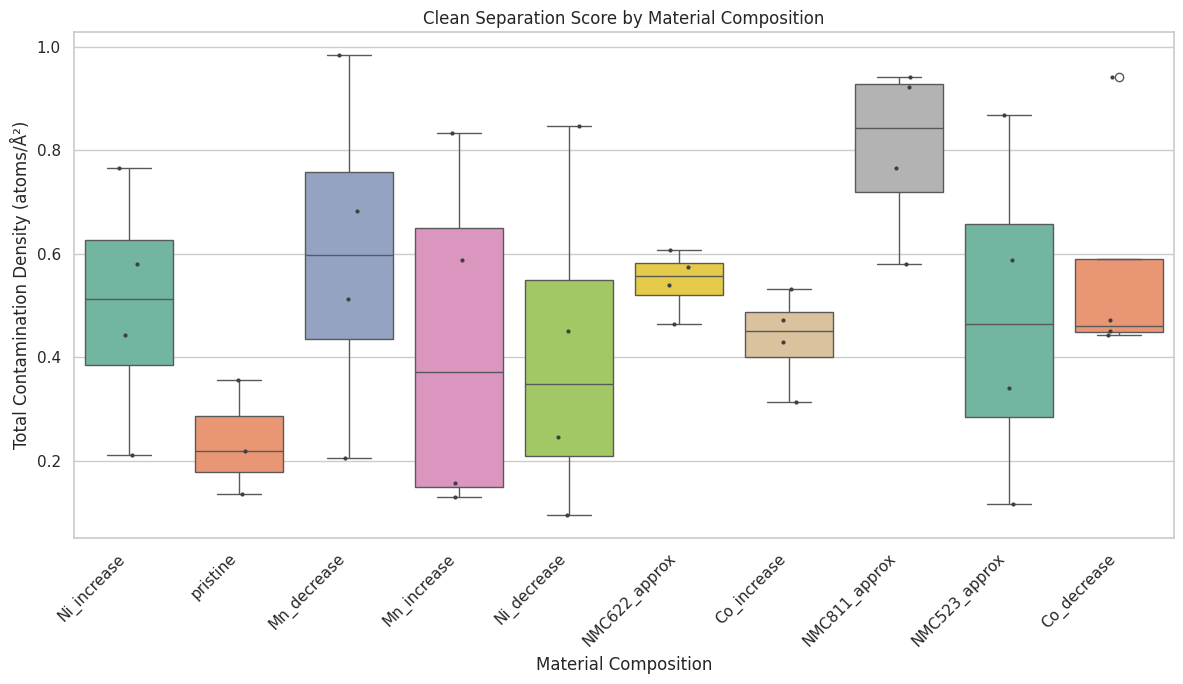

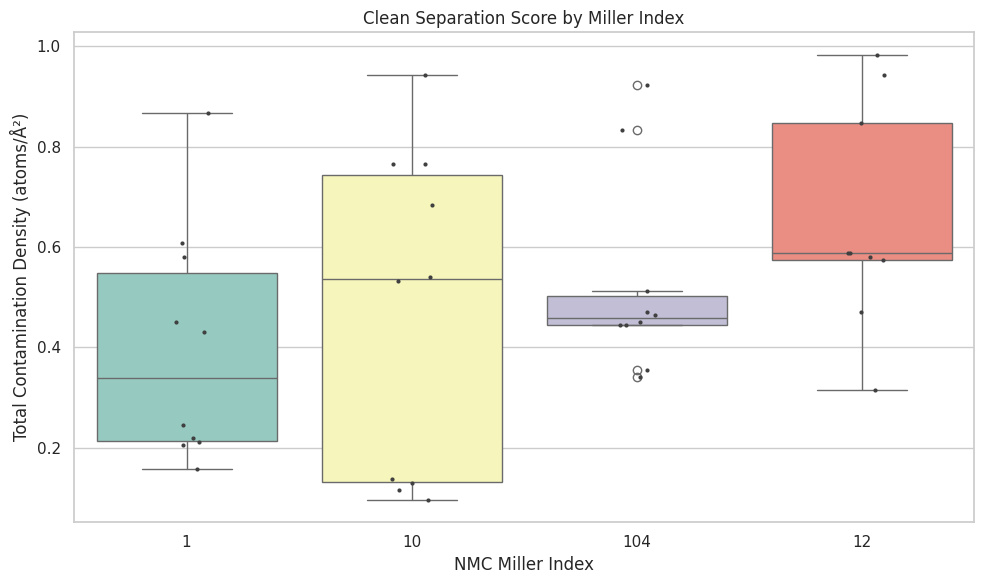

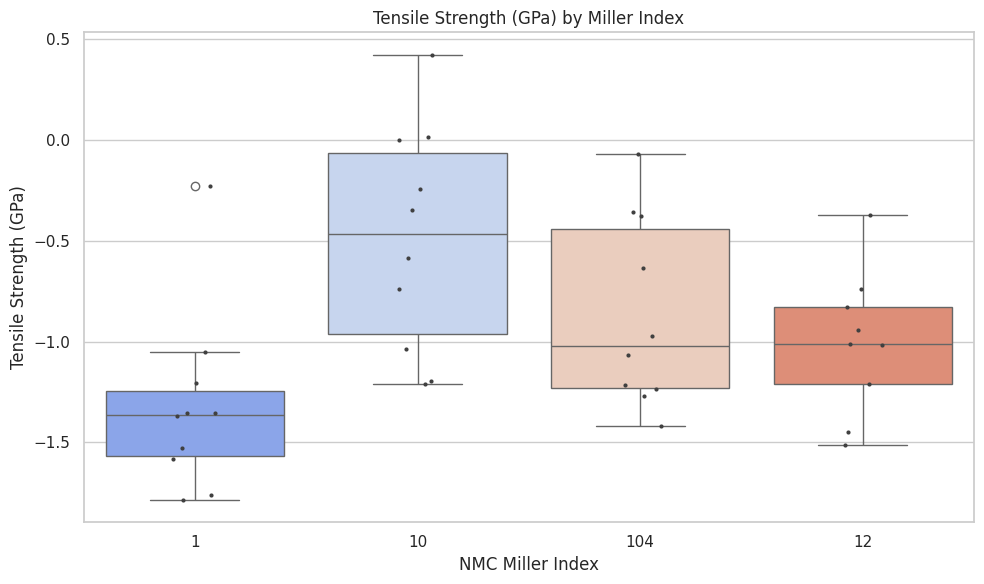

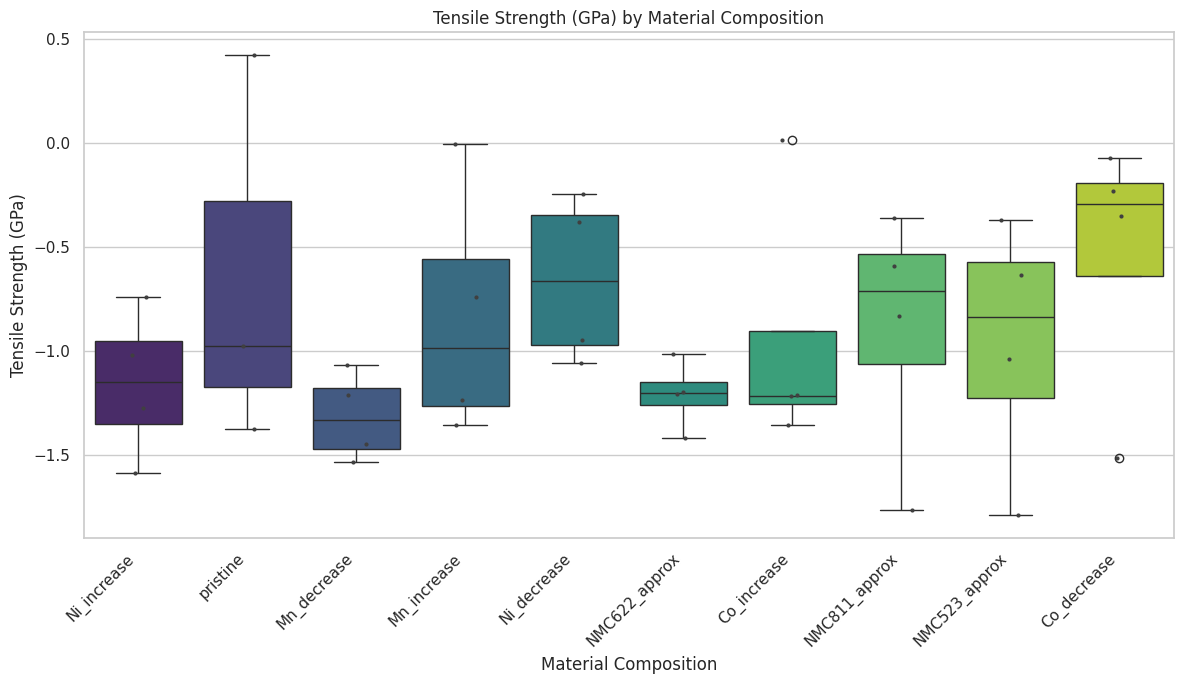

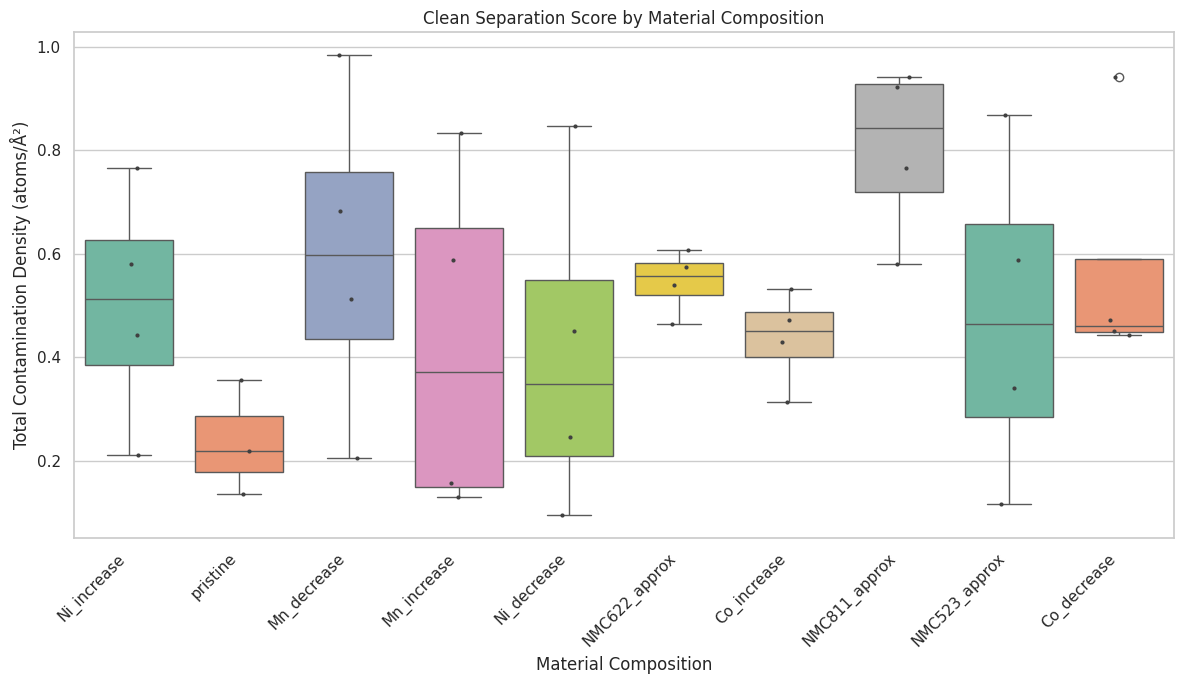

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

# グラフのスタイルを設定
sns.set_theme(style="whitegrid")

# --- 1. データの読み込み ---
file_path = "/home/jovyan/Kaori/MD/LiB_2/structure/MD_Al/output/scored_results_for_clean_separation.csv"
output_dir="/home/jovyan/Kaori/MD/LiB_2/structure/MD_Al/output"
# analysis_output_MD_Al
try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded {file_path}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    sys.exit() # exit() はインタラクティブ環境では推奨されないため sys.exit() に変更

print("\n--- Initial Data Head (First 5 rows) ---")
print(df.head())

# --- 2. カラム存在チェック ---
# CSVファイルに必要なカラムが揃っているか確認します。
required_cols_original = [
    'material', 
    'NMC_miller_index', 
    'total_contam_density', 
    'sub_contam_density', 
    'cat_contam_density'
]
required_cols_new = ['tensile_strength_GPa'] # 追加分析用

missing_cols = []
for col in required_cols_original + required_cols_new:
    if col not in df.columns:
        missing_cols.append(col)

if missing_cols:
    print(f"\nError: 以下の必要なカラムが見つかりません: {', '.join(missing_cols)}")
    print("スクリプトを終了します。CSVファイルの内容を確認してください。")
    sys.exit()
else:
    print("\n必要なカラムがすべて存在することを確認しました。")


# --- (旧セクション2: 'material' カラムの解析と特徴量抽出) ---
# ご要望に基づき、CSVからの直接読み取りを前提とするため、
# 'material' カラムを分割・抽出する処理はすべて削除（または無効化）しました。
print("\n--- Data (First 5 rows) ---")
print(df[['material', 'NMC_miller_index', 'total_contam_density', 'tensile_strength_GPa']].head())


# --- 3. 組成 (material) 別分析 (total_contam_density) ---
print(f"\n--- Analysis by Composition (material) vs. Clean Separation Score ---")
# total_contam_density の基本統計量を計算
composition_analysis = df.groupby('material')['total_contam_density'].describe()
print(composition_analysis)

# --- 4. ミラー指数 (NMC_miller_index) 別分析 (total_contam_density) ---
print(f"\n--- Analysis by Miller Index (NMC_miller_index) vs. Clean Separation Score ---")
# total_contam_density の基本統計量を計算
miller_analysis = df.groupby('NMC_miller_index')['total_contam_density'].describe()
miller_analysis_Al_stability = df.groupby('NMC_miller_index')['sub_contam_density'].describe()
miller_analysis_NMC_stability = df.groupby('NMC_miller_index')['cat_contam_density'].describe()
print(miller_analysis)
print(miller_analysis_Al_stability)
print(miller_analysis_NMC_stability)

# 共通の 'NMC_miller_index' で自動的に結合されます
combined_analysis = pd.concat([miller_analysis_Al_stability, miller_analysis_NMC_stability], axis=1)
output_file_1 = "Al_miller_analysis_summary.csv"
combined_analysis.to_csv(output_file_1, encoding='utf-8-sig')
print(f"Saved stability analysis to: {output_file_1}")

# --- 5. 視覚化 (ボックスプロット - total_contam_density) ---

# 図1: 組成 vs. スコア
plt.figure(figsize=(12, 7))
ax1 = sns.boxplot(data=df, x='material', y='total_contam_density', palette="Set2")
sns.stripplot(data=df, x='material', y='total_contam_density', color=".25", size=3, jitter=True, ax=ax1)
plt.title('Clean Separation Score by Material Composition')
plt.xlabel('Material Composition')
plt.ylabel('Total Contamination Density (atoms/Å²)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plot_file_1 = os.path.join(output_dir,"composition_vs_score_boxplot.png")
plt.savefig(plot_file_1)
print(f"\nGenerated plot: {plot_file_1}")


# 図2: ミラー指数 vs. スコア
plt.figure(figsize=(10, 6))
sorted_indices = sorted(df['NMC_miller_index'].astype(str).unique()) # 文字列としてソート
ax2 = sns.boxplot(data=df, x='NMC_miller_index', y='total_contam_density', palette="Set3", order=sorted_indices)
sns.stripplot(data=df, x='NMC_miller_index', y='total_contam_density', color=".25", size=3, jitter=True, ax=ax2, order=sorted_indices)
plt.title('Clean Separation Score by Miller Index')
plt.xlabel('NMC Miller Index')
plt.ylabel('Total Contamination Density (atoms/Å²)')
plt.tight_layout()
plot_file_2 = os.path.join(output_dir,"miller_index_vs_score_boxplot.png")
plt.savefig(plot_file_2)
print(f"Generated plot: {plot_file_2}")


# --- 6. 【追加】tensile_strength_GPa の集計表 ---
print(f"\n--- Analysis by Miller Index & Material vs. Tensile Strength (GPa) ---")
# 'NMC_miller_index' と 'material' の両方でグループ化し、tensile_strength_GPa の統計量を計算
try:
    tensile_summary = df.groupby(['NMC_miller_index', 'material'])['tensile_strength_GPa'].describe()
    print(tensile_summary)
    
    # 集計表をCSVファイルとして保存
    output_file_tensile = os.path.join(output_dir,"tensile_strength_summary.csv")
    tensile_summary.to_csv(output_file_tensile, encoding='utf-8-sig')
    print(f"Saved tensile strength summary to: {output_file_tensile}")

except KeyError:
    print("Error: 'tensile_strength_GPa' column not found for summary.")
except Exception as e:
    print(f"An error occurred during tensile summary: {e}")


# --- 7. 【追加】tensile_strength_GPa の視覚化 (ボックスプロット) ---

# 図3: ミラー指数 vs. 引張強度
try:
    plt.figure(figsize=(10, 6))
    sorted_indices_tensile = sorted(df['NMC_miller_index'].astype(str).unique()) # 文字列としてソート
    ax3 = sns.boxplot(data=df, x='NMC_miller_index', y='tensile_strength_GPa', palette="coolwarm", order=sorted_indices_tensile)
    sns.stripplot(data=df, x='NMC_miller_index', y='tensile_strength_GPa', color=".25", size=3, jitter=True, ax=ax3, order=sorted_indices_tensile)
    plt.title('Tensile Strength (GPa) by Miller Index')
    plt.xlabel('NMC Miller Index')
    plt.ylabel('Tensile Strength (GPa)')
    plt.tight_layout()
    plot_file_3 =os.path.join(output_dir, "miller_index_vs_tensile_strength_boxplot.png")
    plt.savefig(plot_file_3)
    print(f"\nGenerated plot: {plot_file_3}")

    # 図4: 組成 vs. 引張強度
    plt.figure(figsize=(12, 7))
    ax4 = sns.boxplot(data=df, x='material', y='tensile_strength_GPa', palette="viridis")
    sns.stripplot(data=df, x='material', y='tensile_strength_GPa', color=".25", size=3, jitter=True, ax=ax4)
    plt.title('Tensile Strength (GPa) by Material Composition')
    plt.xlabel('Material Composition')
    plt.ylabel('Tensile Strength (GPa)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plot_file_4 = os.path.join(output_dir,"composition_vs_tensile_strength_boxplot.png")
    plt.savefig(plot_file_4)
    print(f"Generated plot: {plot_file_4}")

    plt.figure(figsize=(12, 7))
    ax1 = sns.boxplot(data=df, x='material', y='total_contam_density', palette="Set2")
    sns.stripplot(data=df, x='material', y='total_contam_density', color=".25", size=3, jitter=True, ax=ax1)
    plt.title('Clean Separation Score by Material Composition')
    plt.xlabel('Material Composition')
    plt.ylabel('Total Contamination Density (atoms/Å²)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plot_file_1 = os.path.join(output_dir,"composition_vs_stability_boxplot.png")
    plt.savefig(plot_file_5)
    print(f"\nGenerated plot: {plot_file_5}")


except KeyError:
    print("Error: 'tensile_strength_GPa' column not found. Skipping tensile plots.")
except Exception as e:
    print(f"An error occurred during tensile plotting: {e}")


# --- 8. 処理済みデータの保存 (元のまま) ---
# (このスクリプトではデータを「処理」していませんが、元のファイル名を維持します)
cleaned_file = "scored_results_cleaned.csv"
df.to_csv(cleaned_file, index=False, encoding='utf-8-sig')
print(f"\nSaved original loaded data to (for consistency): {cleaned_file}")

print("\nAnalysis complete.")

In [68]:
import glob
from ase.io import read
import numpy as np
cif_files = ['/home/jovyan/Kaori/MD/LiB_2/structure/Al2O3_NMC/Interface_Al2O3_on_NMC_Ni_decrease_012.cif', '/home/jovyan/Kaori/MD/LiB_2/structure/AlF3_NMC/Interface_AlF3_on_NMC_Ni_decrease_012.cif','/home/jovyan/Kaori/MD/LiB_2/structure/Al_NMC/Interface_Al_on_NMC_Co_decrease_012.cif']
results = []

# カレントディレクトリの全CIFファイルを処理
for filename in cif_files:
    try:
        atoms = read(filename)
        
        # Al原子のインデックスを取得
        al_indices = [a.index for a in atoms if a.symbol == 'Al']
        # if a.symbol == 'Al'
        # Al原子がなければ次のファイルへ
        if not al_indices:
            print(f"[{filename}] Alなし")
            continue
            
        # Al原子の座標を取得し、Z座標の最大値 (高さ) を計算
        al_positions = atoms.get_positions()[al_indices]
        max_z_height = np.max(al_positions[:, 2])
        max_y_height = np.max(al_positions[:, 1])
        # 結果を (高さ, ファイル名) のタプルで保存
        results.append((max_y_height, filename))

    except Exception as e:
        print(f"[{filename}] エラー: {e}")

# --- 結果を高さ順 (降順) にソートして表示 ---
results.sort(reverse=True)

print("\n--- Al原子の最大高さ (Z座標) リスト (高い順) ---")
for height, filename in results:
    print(f"{filename:<30} : {height:.4f} Å")


--- Al原子の最大高さ (Z座標) リスト (高い順) ---
/home/jovyan/Kaori/MD/LiB_2/structure/Al_NMC/Interface_Al_on_NMC_Co_decrease_012.cif : 12.4466 Å
/home/jovyan/Kaori/MD/LiB_2/structure/Al2O3_NMC/Interface_Al2O3_on_NMC_Ni_decrease_012.cif : 11.6299 Å
/home/jovyan/Kaori/MD/LiB_2/structure/AlF3_NMC/Interface_AlF3_on_NMC_Ni_decrease_012.cif : 11.3046 Å


In [53]:
# -*- coding: utf-8 -*-stabilityの計算修正前
import pandas as pd
import matplotlib.pyplot as plt
from ase.io import Trajectory
from ase import units
import sys
import re
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import interpolate
import glob
from pathlib import Path

# --- 基本設定 ---
# !!! このパスは、.dat と .traj ファイルが保存されている実際のディレクトリに変更してください !!!
TENSILE_DIR = "/home/jovyan/Kaori/MD/LiB_2/structure/MD_Al/tensile01"
# Kaori/MD/LiB_2/structure/MD_Al/tensile01/Al2O3_NMC_Ni_decrease_001__P0.000_T300K_HT500K_tensile_analysis.dat
TENSILE_TEMPERATURE = 300.0

# --- 出力ディレクトリの作成 ---
OUTPUT_BASE_PATH = Path("/home/jovyan/Kaori/MD/LiB_2/structure/MD_Al/output")
OUTPUT_FIGURE_DIR = OUTPUT_BASE_PATH / "stress_strain_curves"
OUTPUT_BASE_PATH.mkdir(exist_ok=True)
OUTPUT_FIGURE_DIR.mkdir(exist_ok=True)

# ==============================================================================
# 応力ひずみ解析モジュール (.dat ファイルベース)
# ==============================================================================

def calculate_yield_stress(strain, stress, youngs_modulus_mpa, offset_strain=0.002):
    """0.2%オフセット法による降伏応力の計算"""
    if np.isnan(youngs_modulus_mpa) or len(strain) < 10:
        return np.nan, np.nan
    try:
        strain_range = np.linspace(offset_strain, strain.max(), 1000)
        offset_line = youngs_modulus_mpa * (strain_range - offset_strain)
        unique_indices = np.unique(strain, return_index=True)[1]
        if len(unique_indices) < 2: return np.nan, np.nan
        interp_func = interpolate.interp1d(strain[unique_indices], stress[unique_indices], kind='linear', bounds_error=False, fill_value='extrapolate')
        actual_stress_at_offset_range = interp_func(strain_range)
        stress_diff = actual_stress_at_offset_range - offset_line
        valid_mask = ~np.isnan(stress_diff)
        if np.sum(valid_mask) < 2: return np.nan, np.nan
        strain_range_valid = strain_range[valid_mask]
        stress_diff_valid = stress_diff[valid_mask]
        sign_changes = np.where(np.diff(np.sign(stress_diff_valid)))[0]
        if len(sign_changes) > 0:
            intersection_idx = sign_changes[0]
            intersection_strain = strain_range_valid[intersection_idx]
            yield_stress = interp_func(intersection_strain)
        else:
            min_diff_idx = np.argmin(np.abs(stress_diff_valid))
            intersection_strain = strain_range_valid[min_diff_idx]
            yield_stress = interp_func(intersection_strain)
        if yield_stress < 0 or intersection_strain < offset_strain: return np.nan, np.nan
        return yield_stress, intersection_strain
    except Exception:
        return np.nan, np.nan

def analyze_stress_strain_from_dat(dat_file_path):
    """
    .datファイルから応力ひずみ曲線を解析し、機械特性を計算する。
    """
    results = {
        'youngs_modulus_GPa': np.nan,
        'tensile_strength_GPa': np.nan,
        'yield_stress_GPa_0.2offset': np.nan,
        'intersection_strain': np.nan
    }
    try:
        data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,
                           names=['Step', 'Strain', 'Stress(GPa)', 'YoungMod(GPa)', 'Status', 'Time(ps)', 'InterfaceNotes'])
        if data.empty:
            return results, None
        strain = data['Strain'].values
        stress_gpa = data['Stress(GPa)'].values
        stress_mpa = stress_gpa * 1000
        linear_range_mask = (strain >= 0.0) & (strain <= 0.05)
        if np.sum(linear_range_mask) > 1:
            X = strain[linear_range_mask].reshape(-1, 1)
            y = stress_mpa[linear_range_mask]
            linear_model = LinearRegression(fit_intercept=False).fit(X, y)
            youngs_modulus_mpa = linear_model.coef_[0]
            results['youngs_modulus_GPa'] = youngs_modulus_mpa / 1000
        else:
            youngs_modulus_mpa = np.nan
        results['tensile_strength_GPa'] = stress_gpa.max()
        yield_stress_mpa, intersection_strain = calculate_yield_stress(strain, stress_mpa, youngs_modulus_mpa)
        if not np.isnan(yield_stress_mpa):
            results['yield_stress_GPa_0.2offset'] = yield_stress_mpa / 1000
            results['intersection_strain'] = intersection_strain
        plot_data = pd.DataFrame({'strain': strain, 'stress': stress_mpa})
        return results, plot_data
    except Exception as e:
        print(f"  - .datファイルの解析中にエラー: {e}")
        return results, None

# ==============================================================================
# 破断界面解析モジュール
# ==============================================================================

def find_fracture_step(traj, void_size=3.0, search_region_ratio=2.0/3.0):
    """Trajectoryをスキャンし、指定サイズの真空層（void）を検出します。"""
    if not traj:
        return None, -1, -1
    for i, atoms in enumerate(traj):
        cell = atoms.get_cell()
        lz = cell[2, 2]
        z_max_search = lz * search_region_ratio
        positions = atoms.get_positions()
        z_coords = positions[:, 2]
        in_region_mask = (z_coords >= 0.0) & (z_coords < z_max_search)
        region_z_coords = z_coords[in_region_mask]
        if len(region_z_coords) < 2:
            continue
        sorted_z = np.sort(region_z_coords)
        gaps = sorted_z[1:] - sorted_z[:-1]
        if np.any(gaps >= void_size):
            max_gap_index = np.argmax(gaps)
            fracture_z = (sorted_z[max_gap_index] + sorted_z[max_gap_index + 1]) / 2.0
            return atoms, i, fracture_z
    return None, -1, -1

def analyze_distribution_at_fracture(atoms, z_boundary):
    """
    破断瞬間の原子スナップショットを基に、境界面上下の原子分布を解析する。
    """
    symbols = atoms.get_chemical_symbols()
    positions = atoms.get_positions()
    elements_to_count = ["Al", "O", "Li", "Mn", "Co", "Ni", "F"]
    results = {elem: {'upper': 0, 'lower': 0, 'total': 0} for elem in elements_to_count}
    for i, symbol in enumerate(symbols):
        if symbol in elements_to_count:
            results[symbol]['total'] += 1
            if positions[i, 2] > z_boundary:
                results[symbol]['upper'] += 1
            else:
                results[symbol]['lower'] += 1
    return results

# ==============================================================================
# ヘルパー関数 (Miller指数読み取り, プロット, スコアリング)
# ==============================================================================

def get_miller_index_from_summary(summary_file_path):
    """_summary.txt ファイルから NMC Miller 指数を抽出する。"""
    if not os.path.exists(summary_file_path):
        return "N/A"
    try:
        with open(summary_file_path, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip().startswith("NMC Miller指数:"):
                    return line.split(':', 1)[1].strip()
    except Exception as e:
        print(f"  [警告] summary.txtの読み取り中にエラー: {e}")
        return "Error"
    return "Not Found"

def plot_stress_strain_curve(data, analysis_results, file_identifier, output_dir):
    """応力-ひずみ曲線と解析結果をプロットして保存する。"""
    if data is None or data.empty: return
    fig_path = os.path.join(output_dir, f"{file_identifier}_ss_curve.png")
    plt.figure(figsize=(10, 7))
    stress_gpa = data['stress'] / 1000
    plt.plot(data['strain'], stress_gpa, label='Original Data', alpha=0.7)
    youngs_modulus_gpa = analysis_results.get('youngs_modulus_GPa', np.nan)
    if not np.isnan(youngs_modulus_gpa):
        linear_range_strain = data[(data['strain'] >= 0.0) & (data['strain'] <= 0.05)]['strain']
        linear_fit_gpa = youngs_modulus_gpa * linear_range_strain
        plt.plot(linear_range_strain, linear_fit_gpa, 'r-', linewidth=2, label=f'Young\'s Modulus Fit ({youngs_modulus_gpa:.1f} GPa)')
    yield_stress_gpa = analysis_results.get('yield_stress_GPa_0.2offset', np.nan)
    intersection_strain = analysis_results.get('intersection_strain', np.nan)
    if not np.isnan(yield_stress_gpa) and not np.isnan(intersection_strain):
        offset_strain_range = np.linspace(0.002, data['strain'].max(), 100)
        offset_line_gpa = (youngs_modulus_gpa * (offset_strain_range - 0.002))
        plt.plot(offset_strain_range, offset_line_gpa, 'g--', label='0.2% Offset Line')
        plt.scatter([intersection_strain], [yield_stress_gpa], color='orange', s=150, marker='*', zorder=5, label=f'Yield Point ({yield_stress_gpa:.2f} GPa)')
    plt.title(f'Stress-Strain Curve for {file_identifier}', fontsize=14)
    plt.xlabel('Strain', fontsize=12)
    plt.ylabel('Stress (GPa)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(fig_path, dpi=300)
    plt.close()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression

# calculate_yield_stress 関数が未定義でしたので、
# 一般的な0.2%オフセット法を（前回までの会話から推測して）ここに定義します。
def calculate_yield_stress(strain_array, stress_array_mpa, youngs_modulus_mpa):
    """ 0.2%オフセット法で降伏応力を計算する """
    if np.isnan(youngs_modulus_mpa) or youngs_modulus_mpa == 0:
        return np.nan, np.nan

    # 0.2%オフセットライン (y = E * (x - 0.002))
    # strain_arrayは既に0から始まると仮定
    offset_line_stress = youngs_modulus_mpa * (strain_array - 0.002)

    # 元の応力曲線とオフセットラインの交点を探す
    # 差分を計算
    stress_diff = stress_array_mpa - offset_line_stress

    # 差分が0をまたぐ（符号が変わる）箇所を探す
    # np.sign(stress_diff) は -1, 0, 1 を返す
    # np.diff(...) で隣り合う要素の差を計算
    # 符号が変わる点 (e.g., -1 -> 1) は diff が 0 でなくなる
    sign_changes = np.where(np.diff(np.sign(stress_diff)))[0]

    # 0.002（2%ひずみ）より大きく、かつ応力が正の領域で、
    # 最初に交差する点を見つける
    for idx in sign_changes:
        if strain_array[idx] > 0.002 and stress_array_mpa[idx] > 0:
            # 線形補間で交点を精密に計算
            x1, x2 = strain_array[idx], strain_array[idx+1]
            y1_data, y2_data = stress_array_mpa[idx], stress_array_mpa[idx+1]
            y1_off, y2_off = offset_line_stress[idx], offset_line_stress[idx+1]

            # (y_data - y_offset) = 0 になる点を解く
            # 簡単のため、データ点とオフセットラインの差分の符号が変わった点で
            # データ点の方の応力を降伏応力とみなす（簡易計算）
            # または、より精密には...
            try:
                # 2直線の交点を求める
                # Data line: y = a1*x + b1
                a1 = (y2_data - y1_data) / (x2 - x1)
                b1 = y1_data - a1 * x1
                # Offset line: y = a2*x + b2 (a2 = E)
                a2 = youngs_modulus_mpa
                b2 = -0.002 * youngs_modulus_mpa

                # 交点のx座標 (a1*x + b1 = a2*x + b2)
                # x = (b2 - b1) / (a1 - a2)
                if (a1 - a2) == 0: continue # 平行
                
                intersection_strain = (b2 - b1) / (a1 - a2)
                intersection_stress = a1 * intersection_strain + b1
                
                # 交点がセグメント内にあることを確認
                if x1 <= intersection_strain <= x2:
                     return intersection_stress, intersection_strain
            except ZeroDivisionError:
                continue

    return np.nan, np.nan


def analyze_stress_strain_from_dat(dat_file_path):
    """
    .datファイルから応力ひずみ曲線を解析し、機械特性を計算する。
    応力(Stress)列を「圧力(圧縮が正)」とみなし、-1を乗じて「応力(引張が正)」に変換する。
    応力が0に最も近い点を解析開始点（ひずみ0）として扱う。
    """
    results = {
        'youngs_modulus_GPa': np.nan,
        'tensile_strength_GPa': np.nan,
        'yield_stress_GPa_0.2offset': np.nan,
        'intersection_strain': np.nan,
        'strain_at_zero_stress': 0.0, # プロット用にゼロ点ひずみを保存
        'stress_at_zero_stress_GPa': 0.0 # プロット用にゼロ点応力を保存
    }
    try:
        data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,
                           names=['Step', 'Strain', 'Stress(GPa)', 'YoungMod(GPa)', 'Status', 'Time(ps)', 'InterfaceNotes'])
        if data.empty:
            return results, None

        # --- 修正点 1: 応力の符号を universally 修正 ---
        # "Stress(GPa)" 列は「圧力 (圧縮が正)」として読み込み、-1を掛けて「応力 (引張が正)」に変換
        strain = data['Strain'].values
        stress_gpa = data['Stress(GPa)'].values 
        
        # --- 修正点 2: 解析開始点（応力ゼロ点）の特定 ---
        # 応力（σ_zz）が0に最も近い点のインデックスを探す
        zero_stress_index = np.abs(stress_gpa).argmin()

        # その点のひずみと応力を記録（プロット用）
        strain_offset = strain[zero_stress_index]
        stress_offset_gpa = stress_gpa[zero_stress_index]
        results['strain_at_zero_stress'] = strain_offset
        results['stress_at_zero_stress_GPa'] = stress_offset_gpa

        # --- 修正点 3: 解析用データ（スライス）の作成 ---
        # ゼロ点以降のデータを解析対象とする
        strain_analysis_raw = strain[:]
        stress_gpa_analysis_raw = stress_gpa[:]

        # ヤング率や降伏応力の計算のために、
        # このゼロ点を原点(0,0)に移動させたデータセットを作成
        strain_analysis = strain_analysis_raw - strain_offset
        stress_gpa_analysis = stress_gpa_analysis_raw - stress_offset_gpa # 応力もゼロにリセット
        stress_mpa_analysis = stress_gpa_analysis * 1000

        if strain_analysis.size < 2: # 解析に十分なデータがない場合
            return results, None

        # --- 修正点 4: スライスしたデータで解析 ---
        # ヤング率の計算 (ひずみ 0% から 5% の範囲)
        # strain_analysis は既に 0 から始まっている
        linear_range_mask = (strain_analysis >= 0.0) & (strain_analysis <= 0.05)
        
        if np.sum(linear_range_mask) > 1:
            X = strain_analysis[linear_range_mask].reshape(-1, 1)
            y = stress_mpa_analysis[linear_range_mask]
            
            # fit_intercept=False のまま (原点を通るようにフィッティング)
            linear_model = LinearRegression(fit_intercept=False).fit(X, y)
            youngs_modulus_mpa = linear_model.coef_[0]
            
            # ヤング率は負にはならないはず
            if youngs_modulus_mpa > 0:
                results['youngs_modulus_GPa'] = youngs_modulus_mpa / 1000
            else:
                youngs_modulus_mpa = np.nan
        else:
            youngs_modulus_mpa = np.nan

        # 最大引張強度 (解析対象スライス内の最大値)
        results['tensile_strength_GPa'] = stress_gpa_analysis_raw.max() # オフセット前の応力での最大値

        # 降伏応力の計算 (0.2% オフセット)
        # calculate_yield_stress には原点補正したデータを渡す
        yield_stress_mpa, intersection_strain_relative = calculate_yield_stress(strain_analysis, stress_mpa_analysis, youngs_modulus_mpa)
        
        if not np.isnan(yield_stress_mpa):
            # 降伏応力はオフセット補正後の値
            results['yield_stress_GPa_0.2offset'] = (yield_stress_mpa + stress_offset_gpa * 1000) / 1000
            # 交点ひずみは「絶対ひずみ」に戻す
            results['intersection_strain'] = intersection_strain_relative + strain_offset
        
        # プロット用には、符号を修正した「全体」のデータを渡す
        plot_data = pd.DataFrame({'strain': strain, 'stress': stress_gpa * 1000})
        
        return results, plot_data
    
    except Exception as e:
        print(f"  - .datファイルの解析中にエラー: {e}")
        return results, None

def plot_stress_strain_curve(data, analysis_results, file_identifier, output_dir):
    """応力-ひずみ曲線と解析結果をプロットして保存する。"""
    if data is None or data.empty: return
    
    fig_path = os.path.join(output_dir, f"{file_identifier}_ss_curve.png")
    plt.figure(figsize=(10, 7))

    # --- 修正点 1: プロットデータを準備 ---
    # data['stress'] は既に符号修正済み (MPa単位)
    stress_gpa = data['stress'] / 1000
    strain = data['strain']
    
    # 符号修正後の全データをプロット
    plt.plot(strain, stress_gpa, label='Stress-Strain Curve', alpha=0.7)
    
    # 解析の基準となった「ゼロ点」を取得
    strain_at_zero = analysis_results.get('strain_at_zero_stress', 0.0)
    stress_at_zero_gpa = analysis_results.get('stress_at_zero_stress_GPa', 0.0)

    youngs_modulus_gpa = analysis_results.get('youngs_modulus_GPa', np.nan)

    # --- 修正点 2: ヤング率のフィット線をゼロ点から描画 ---
    if not np.isnan(youngs_modulus_gpa):
        # フィット線は (strain_at_zero, stress_at_zero_gpa) から開始
        fit_strain_end = strain_at_zero + 0.05
        fit_strain_end = min(fit_strain_end, strain.max())
        
        linear_range_strain = np.linspace(strain_at_zero, fit_strain_end, 10)
        # y = m * (x - x0) + y0
        linear_fit_gpa = youngs_modulus_gpa * (linear_range_strain - strain_at_zero) + stress_at_zero_gpa
        
        plt.plot(linear_range_strain, linear_fit_gpa, 'r-', linewidth=2, 
                 label=f'Young\'s Modulus Fit ({youngs_modulus_gpa:.1f} GPa)')

    yield_stress_gpa = analysis_results.get('yield_stress_GPa_0.2offset', np.nan)
    intersection_strain = analysis_results.get('intersection_strain', np.nan) # これは絶対ひずみ

    # --- 修正点 3: オフセット線をゼロ点基準で描画 ---
    if not np.isnan(yield_stress_gpa) and not np.isnan(intersection_strain):
        # オフセット線は (strain_at_zero + 0.002, stress_at_zero_gpa) から開始
        offset_start_strain = strain_at_zero + 0.002
        offset_strain_range = np.linspace(offset_start_strain, strain.max(), 100)
        
        # y = m * (x - (x0 + 0.002)) + y0
        offset_line_gpa = youngs_modulus_gpa * (offset_strain_range - offset_start_strain) + stress_at_zero_gpa

        plt.plot(offset_strain_range, offset_line_gpa, 'g--', label='0.2% Offset Line')
        
        # 降伏点は絶対座標でプロット
        plt.scatter([intersection_strain], [yield_stress_gpa], color='orange', s=150, 
                    marker='*', zorder=5, label=f'Yield Point ({yield_stress_gpa:.2f} GPa)')

    plt.title(f'Stress-Strain Curve for {file_identifier}', fontsize=14)
    plt.xlabel('Strain', fontsize=12)
    plt.ylabel('Stress (GPa)', fontsize=12)
    
    # 応力0のラインを点線で引く
    plt.axhline(0, color='black', linestyle=':', linewidth=1, label='Zero Stress')
    
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(fig_path, dpi=300)
    plt.close()
    
def calculate_clean_separation_score(df):
    """界面がどれだけきれいに分離したかを評価するスコアを計算する。"""
    if 'Al_total' in df.columns and df['Al_total'].sum() > 0:
        df['substrate_stability'] = (df['Al_lower'] / df['Al_total']).fillna(0)
    else:
        df['substrate_stability'] = 0.5
    cathode_elements = ['Li', 'Mn', 'Co', 'Ni']
    upper_sum = pd.Series(0, index=df.index)
    total_sum = pd.Series(0, index=df.index)
    for elem in cathode_elements:
        if f'{elem}_total' in df.columns:
            upper_sum += df[f'{elem}_upper'].fillna(0)
            total_sum += df[f'{elem}_total'].fillna(0)
    df['cathode_stability'] = (upper_sum / total_sum).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['clean_separation_score'] = (df['substrate_stability'] + df['cathode_stability']) / 2
    return df

def normalize_metric(series, high_is_good=True):
    """PandasのSeriesをミンマックス正規化する。"""
    series_finite = series.replace([np.inf, -np.inf], np.nan).fillna(0)
    min_val, max_val = series_finite.min(), series_finite.max()
    if max_val - min_val == 0:
        return pd.Series(0.5, index=series.index)
    if high_is_good:
        return (series_finite - min_val) / (max_val - min_val)
    else:
        return (max_val - series_finite) / (max_val - min_val)

def score_for_clean_separation(csv_path=OUTPUT_BASE_PATH/"comprehensive_analysis_results.csv"):
    """「分離しやすく、きれいな分離」という基準で結果をスコアリングする。"""
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"エラー: ファイルが見つかりません '{csv_path}'")
        return
    print("\n\n=== スコアリングを開始します ===")
    metrics_config = {
        'tensile_strength_GPa': {'weight': 0.4, 'high_is_good': False},
        'fracture_step':        {'weight': 0.2, 'high_is_good': False},
        'clean_separation_score': {'weight': 0.4, 'high_is_good': True},
    }
    df = calculate_clean_separation_score(df)
    df['総合スコア'] = 0.0
    print("\n評価指標と方針:")
    for metric, config in metrics_config.items():
        direction = "低いほど高評価" if not config['high_is_good'] else "高いほど高評価"
        print(f"- {metric}: 重み {config['weight']*100:.0f}%, ({direction})")
        df[metric].fillna(0, inplace=True)
        normalized_col_name = f'norm_{metric}'
        df[normalized_col_name] = normalize_metric(df[metric], high_is_good=config['high_is_good'])
        df['総合スコア'] += df[normalized_col_name] * config['weight']
    df['総合スコア'] *= 100
    df_sorted = df.sort_values(by='総合スコア', ascending=False)
    display_columns = ['substrate', 'material', 'NMC_miller_index', 'pressure_GPa', 'high_temp_K', '総合スコア'] + list(metrics_config.keys())
    print("\n--- スコアリング結果トップ10 (分離しやすさ・きれいさ重視) ---")
    print(df_sorted[display_columns].head(10).round(2))
    output_filename = OUTPUT_BASE_PATH/"scored_results_for_clean_separation.csv"
    df_sorted.to_csv(output_filename, index=False)
    print(f"\n全スコアリング結果を '{output_filename}' に保存しました。")


# ==============================================================================
# メイン実行ブロック
# ==============================================================================

def run_comprehensive_analysis_with_dat():
    dat_paths = glob.glob(os.path.join(TENSILE_DIR, '*_tensile_analysis.dat'))
    if not dat_paths:
        print(f"エラー: ディレクトリ '{TENSILE_DIR}' 内に `..._tensile_analysis.dat` ファイルが見つかりません。")
        return

    all_results_list = []
    total_files = len(dat_paths)
    print(f"=== 包括的解析を開始します (.datファイルベース, 対象ファイル数: {total_files}) ===")
    
    for i, dat_path in enumerate(dat_paths):
        filename = os.path.basename(dat_path)
        print(f"\n--- ({i+1}/{total_files}) 処理中: {filename} ---")
        pattern = re.compile(r'([^_]+)_(.*)__P(\d+\.\d+)_T(\d+)K_HT(\d+)K_tensile_analysis\.dat')
        match = pattern.match(filename)
        if not match:
            print(f"[スキップ] ファイル名の形式がパターンに一致しません: {filename}")
            continue
        sub, base_name, pressure, comp_temp, high_temp = match.groups()
        pressure, comp_temp, high_temp = float(pressure), int(comp_temp), int(high_temp)
        split_list = base_name.split('_')

        # 'NMC' がある場所のインデックスを取得 (この例では 1)
        nmc_index = split_list.index('NMC')
        
        # 'NMC'の次 (インデックス 2) から
        # 最後の要素 (-1) の手前までをスライスします
        # -> ['Ni', 'increase']
        composition_parts = split_list[nmc_index + 1 : -1]
        print(composition_parts)
        nmc_miller_index = f"{int(split_list[-1]):03d}"
        # スライスしたリストを '_' で連結します
        material = '_'.join(composition_parts)
        
        print(f"split_list: {split_list}")
        print(f"抽出された material: {material}")
    
        # 'NMC' が見つからなかったり、リストが短すぎる場合の処理
    
        # # Miller指数を取得
        # summary_filename1 = filename.replace('_analysis.dat', '_summary.txt')
        # summary_filename = summary_filename1.replace('__', '_')
        # summary_path = os.path.join(TENSILE_DIR, summary_filename)
        # nmc_miller_index = get_miller_index_from_summary(summary_path)
        # print(f"  NMC Miller指数: {nmc_miller_index}")

        # 応力ひずみ解析
        ss_results, ss_data = analyze_stress_strain_from_dat(dat_path)
        if ss_data is not None:
            print("  応力ひずみ解析完了。")
            file_identifier = f"{sub}_{base_name}_P{pressure:.3f}_T{comp_temp:.0f}K_HT{high_temp}K"
            plot_stress_strain_curve(ss_data, ss_results, file_identifier, OUTPUT_FIGURE_DIR)
        else:
            print("  応力ひずみ解析不可。")

        # 破断界面解析
        traj_filename1 = filename.replace('_tensile_analysis.dat', f'_tensile{TENSILE_TEMPERATURE:.0f}K.traj')
        traj_filename = traj_filename1.replace('__', '_')
        traj_path = os.path.join(TENSILE_DIR, traj_filename)
        fracture_results = {}
        if os.path.exists(traj_path):
            try:
                traj = Trajectory(traj_path, 'r')
                if len(traj) > 0:
                    fractured_atoms, step, z_loc = find_fracture_step(traj)
                    if fractured_atoms is not None:
                        print(f"  破断を発見 (ステップ: {step}, Z座標: {z_loc:.2f} Å)。")
                        dist = analyze_distribution_at_fracture(fractured_atoms, z_loc)
                        fracture_results.update({'fracture_step': step, 'fracture_z': z_loc})
                        for elem, counts in dist.items():
                            fracture_results[f'{elem}_upper'] = counts['upper']
                            fracture_results[f'{elem}_lower'] = counts['lower']
                            fracture_results[f'{elem}_total'] = counts['total']
                    else:
                        print("  指定サイズのギャップは見つかりませんでした。")
            except Exception as e:
                print(f"  [エラー] .trajファイルの処理中に問題が発生: {e}")
        else:
            print(f"  [警告] 対応する .traj ファイルが見つかりません: {traj_filename}")

        # 結果を統合
        row = {'substrate': sub, 'material': material, 'pressure_GPa': pressure, 
               'comp_temp_K': comp_temp, 'high_temp_K': high_temp, 'NMC_miller_index': nmc_miller_index}
        row.update(ss_results)
        row.update(fracture_results)
        all_results_list.append(row)

    print("\n\n=== すべての解析が完了しました ===")
    if not all_results_list:
        print("有効な解析結果がありませんでした。")
        return

    # 結果をCSVに保存
    df = pd.DataFrame(all_results_list)
    basic_cols = ['substrate', 'material', 'NMC_miller_index', 'pressure_GPa', 'comp_temp_K', 'high_temp_K']
    analysis_cols = [col for col in df.columns if col not in basic_cols]
    df = df[basic_cols + analysis_cols]
    output_csv_path = OUTPUT_BASE_PATH / "comprehensive_analysis_results.csv"
    df.to_csv(output_csv_path, index=False)
    print(f"結果を {output_csv_path} に保存しました。")

if __name__ == "__main__":
    # 1. メインの解析を実行
    run_comprehensive_analysis_with_dat()
    
    # 2. 生成されたCSVファイルを使ってスコアリングを実行
    score_for_clean_separation()

=== 包括的解析を開始します (.datファイルベース, 対象ファイル数: 40) ===

--- (1/40) 処理中: AlF3_NMC_Ni_increase_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Ni', 'increase']
split_list: ['NMC', 'Ni', 'increase', '001']
抽出された material: Ni_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 101, Z座標: 16.57 Å)。

--- (2/40) 処理中: AlF3_NMC_Ni_decrease_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Ni', 'decrease']
split_list: ['NMC', 'Ni', 'decrease', '104']
抽出された material: Ni_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 46, Z座標: 32.65 Å)。

--- (3/40) 処理中: AlF3_NMC_NMC811_approx_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC811', 'approx']
split_list: ['NMC', 'NMC811', 'approx', '104']
抽出された material: NMC811_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 69, Z座標: 28.55 Å)。

--- (4/40) 処理中: AlF3_NMC_Co_increase_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Co', 'increase']
split_list: ['NMC', 'Co', 'increase', '012']
抽出された material: Co_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 50, Z座標: 23.55 Å)。

--- (5/40) 処理中: AlF3_NMC_pristine_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['pristine']
split_list: ['NMC', 'pristine', '104']
抽出された material: pristine
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 69, Z座標: 8.26 Å)。

--- (6/40) 処理中: AlF3_NMC_NMC811_approx_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC811', 'approx']
split_list: ['NMC', 'NMC811', 'approx', '010']
抽出された material: NMC811_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 100, Z座標: 35.53 Å)。

--- (7/40) 処理中: AlF3_NMC_pristine_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['pristine']
split_list: ['NMC', 'pristine', '010']
抽出された material: pristine
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 74, Z座標: 37.89 Å)。

--- (8/40) 処理中: AlF3_NMC_NMC622_approx_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC622', 'approx']
split_list: ['NMC', 'NMC622', 'approx', '104']
抽出された material: NMC622_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 105, Z座標: 39.88 Å)。

--- (9/40) 処理中: AlF3_NMC_Co_increase_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Co', 'increase']
split_list: ['NMC', 'Co', 'increase', '010']
抽出された material: Co_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 124, Z座標: 12.77 Å)。

--- (10/40) 処理中: AlF3_NMC_NMC811_approx_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC811', 'approx']
split_list: ['NMC', 'NMC811', 'approx', '012']
抽出された material: NMC811_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 67, Z座標: 31.28 Å)。

--- (11/40) 処理中: AlF3_NMC_Ni_decrease_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Ni', 'decrease']
split_list: ['NMC', 'Ni', 'decrease', '012']
抽出された material: Ni_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 146, Z座標: 51.61 Å)。

--- (12/40) 処理中: AlF3_NMC_Co_decrease_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Co', 'decrease']
split_list: ['NMC', 'Co', 'decrease', '012']
抽出された material: Co_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 86, Z座標: 36.89 Å)。

--- (13/40) 処理中: AlF3_NMC_Co_increase_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Co', 'increase']
split_list: ['NMC', 'Co', 'increase', '104']
抽出された material: Co_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 97, Z座標: 12.55 Å)。

--- (14/40) 処理中: AlF3_NMC_Mn_increase_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Mn', 'increase']
split_list: ['NMC', 'Mn', 'increase', '104']
抽出された material: Mn_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 140, Z座標: 13.61 Å)。

--- (15/40) 処理中: AlF3_NMC_Ni_increase_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Ni', 'increase']
split_list: ['NMC', 'Ni', 'increase', '104']
抽出された material: Ni_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 59, Z座標: 38.50 Å)。

--- (16/40) 処理中: AlF3_NMC_NMC523_approx_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC523', 'approx']
split_list: ['NMC', 'NMC523', 'approx', '010']
抽出された material: NMC523_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 61, Z座標: 38.41 Å)。

--- (17/40) 処理中: AlF3_NMC_Mn_increase_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Mn', 'increase']
split_list: ['NMC', 'Mn', 'increase', '010']
抽出された material: Mn_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 44, Z座標: 9.75 Å)。

--- (18/40) 処理中: AlF3_NMC_pristine_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['pristine']
split_list: ['NMC', 'pristine', '012']
抽出された material: pristine
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 62, Z座標: 29.82 Å)。

--- (19/40) 処理中: AlF3_NMC_pristine_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['pristine']
split_list: ['NMC', 'pristine', '001']
抽出された material: pristine
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 69, Z座標: 32.13 Å)。

--- (20/40) 処理中: AlF3_NMC_Mn_increase_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Mn', 'increase']
split_list: ['NMC', 'Mn', 'increase', '001']
抽出された material: Mn_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 29, Z座標: 9.85 Å)。

--- (21/40) 処理中: AlF3_NMC_NMC523_approx_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC523', 'approx']
split_list: ['NMC', 'NMC523', 'approx', '001']
抽出された material: NMC523_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 140, Z座標: 44.06 Å)。

--- (22/40) 処理中: AlF3_NMC_Mn_decrease_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Mn', 'decrease']
split_list: ['NMC', 'Mn', 'decrease', '012']
抽出された material: Mn_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 130, Z座標: 26.41 Å)。

--- (23/40) 処理中: AlF3_NMC_Ni_increase_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Ni', 'increase']
split_list: ['NMC', 'Ni', 'increase', '012']
抽出された material: Ni_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 64, Z座標: 40.71 Å)。

--- (24/40) 処理中: AlF3_NMC_NMC523_approx_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC523', 'approx']
split_list: ['NMC', 'NMC523', 'approx', '104']
抽出された material: NMC523_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 75, Z座標: 7.98 Å)。

--- (25/40) 処理中: AlF3_NMC_NMC622_approx_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC622', 'approx']
split_list: ['NMC', 'NMC622', 'approx', '010']
抽出された material: NMC622_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 134, Z座標: 20.19 Å)。

--- (26/40) 処理中: AlF3_NMC_NMC523_approx_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC523', 'approx']
split_list: ['NMC', 'NMC523', 'approx', '012']
抽出された material: NMC523_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 110, Z座標: 22.72 Å)。

--- (27/40) 処理中: AlF3_NMC_Ni_decrease_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Ni', 'decrease']
split_list: ['NMC', 'Ni', 'decrease', '010']
抽出された material: Ni_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 103, Z座標: 49.47 Å)。

--- (28/40) 処理中: AlF3_NMC_Ni_increase_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Ni', 'increase']
split_list: ['NMC', 'Ni', 'increase', '010']
抽出された material: Ni_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 52, Z座標: 32.70 Å)。

--- (29/40) 処理中: AlF3_NMC_Mn_decrease_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Mn', 'decrease']
split_list: ['NMC', 'Mn', 'decrease', '010']
抽出された material: Mn_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 65, Z座標: 40.37 Å)。

--- (30/40) 処理中: AlF3_NMC_NMC622_approx_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC622', 'approx']
split_list: ['NMC', 'NMC622', 'approx', '012']
抽出された material: NMC622_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 75, Z座標: 40.37 Å)。

--- (31/40) 処理中: AlF3_NMC_Mn_increase_012__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Mn', 'increase']
split_list: ['NMC', 'Mn', 'increase', '012']
抽出された material: Mn_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 162, Z座標: 11.47 Å)。

--- (32/40) 処理中: AlF3_NMC_Co_decrease_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Co', 'decrease']
split_list: ['NMC', 'Co', 'decrease', '001']
抽出された material: Co_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 56, Z座標: 29.44 Å)。

--- (33/40) 処理中: AlF3_NMC_NMC811_approx_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC811', 'approx']
split_list: ['NMC', 'NMC811', 'approx', '001']
抽出された material: NMC811_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 51, Z座標: 30.69 Å)。

--- (34/40) 処理中: AlF3_NMC_Co_decrease_010__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Co', 'decrease']
split_list: ['NMC', 'Co', 'decrease', '010']
抽出された material: Co_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 84, Z座標: 42.14 Å)。

--- (35/40) 処理中: AlF3_NMC_Co_increase_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Co', 'increase']
split_list: ['NMC', 'Co', 'increase', '001']
抽出された material: Co_increase
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 41, Z座標: 29.61 Å)。

--- (36/40) 処理中: AlF3_NMC_Co_decrease_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Co', 'decrease']
split_list: ['NMC', 'Co', 'decrease', '104']
抽出された material: Co_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 56, Z座標: 31.27 Å)。

--- (37/40) 処理中: AlF3_NMC_Mn_decrease_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Mn', 'decrease']
split_list: ['NMC', 'Mn', 'decrease', '001']
抽出された material: Mn_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 28, Z座標: 26.92 Å)。

--- (38/40) 処理中: AlF3_NMC_NMC622_approx_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['NMC622', 'approx']
split_list: ['NMC', 'NMC622', 'approx', '001']
抽出された material: NMC622_approx
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 86, Z座標: 38.10 Å)。

--- (39/40) 処理中: AlF3_NMC_Mn_decrease_104__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Mn', 'decrease']
split_list: ['NMC', 'Mn', 'decrease', '104']
抽出された material: Mn_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 92, Z座標: 34.60 Å)。

--- (40/40) 処理中: AlF3_NMC_Ni_decrease_001__P0.000_T300K_HT500K_tensile_analysis.dat ---
['Ni', 'decrease']
split_list: ['NMC', 'Ni', 'decrease', '001']
抽出された material: Ni_decrease
  応力ひずみ解析完了。


/tmp/ipykernel_35587/2717952435.py:267: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 35, Z座標: 27.81 Å)。


=== すべての解析が完了しました ===
結果を /home/jovyan/Kaori/MD/LiB_2/structure/MD_AlF3/output/comprehensive_analysis_results.csv に保存しました。


=== スコアリングを開始します ===

評価指標と方針:
- tensile_strength_GPa: 重み 40%, (低いほど高評価)
- fracture_step: 重み 20%, (低いほど高評価)
- clean_separation_score: 重み 40%, (高いほど高評価)

--- スコアリング結果トップ10 (分離しやすさ・きれいさ重視) ---
   substrate       material  NMC_miller_index  pressure_GPa  high_temp_K  \
1       AlF3    Ni_decrease               104           0.0          500   
22      AlF3    Ni_increase                12           0.0          500   
27      AlF3    Ni_increase                10           0.0          500   
36      AlF3    Mn_decrease                 1           0.0          500   
14      AlF3    Ni_increase               104           0.0          500   
28      AlF3    Mn_decrease                10           0.0          500   
35      AlF3    Co_decrease               104           0.0          500   
29      AlF3  NMC622_approx             

/tmp/ipykernel_35587/2717952435.py:456: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[metric].fillna(0, inplace=True)
/tmp/ipykernel_35587/2717952435.py:456: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [ ]:
#stanility, clean separation score修正前
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

# グラフのスタイルを設定
sns.set_theme(style="whitegrid")

# --- 1. データの読み込み ---
file_path = "/home/jovyan/Kaori/MD/LiB_2/structure/MD_Al/output/scored_results_for_clean_separation.csv"
output_dir="/home/jovyan/Kaori/MD/LiB_2/structure/MD_Al/output"
# analysis_output_MD_Al
try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded {file_path}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    sys.exit() # exit() はインタラクティブ環境では推奨されないため sys.exit() に変更

print("\n--- Initial Data Head (First 5 rows) ---")
print(df.head())

# --- 2. カラム存在チェック ---
# CSVファイルに必要なカラムが揃っているか確認します。
required_cols_original = [
    'material', 
    'NMC_miller_index', 
    'clean_separation_score', 
    'substrate_stability', 
    'cathode_stability'
]
required_cols_new = ['tensile_strength_GPa'] # 追加分析用

missing_cols = []
for col in required_cols_original + required_cols_new:
    if col not in df.columns:
        missing_cols.append(col)

if missing_cols:
    print(f"\nError: 以下の必要なカラムが見つかりません: {', '.join(missing_cols)}")
    print("スクリプトを終了します。CSVファイルの内容を確認してください。")
    sys.exit()
else:
    print("\n必要なカラムがすべて存在することを確認しました。")


# --- (旧セクション2: 'material' カラムの解析と特徴量抽出) ---
# ご要望に基づき、CSVからの直接読み取りを前提とするため、
# 'material' カラムを分割・抽出する処理はすべて削除（または無効化）しました。
print("\n--- Data (First 5 rows) ---")
print(df[['material', 'NMC_miller_index', 'clean_separation_score', 'tensile_strength_GPa']].head())


# --- 3. 組成 (material) 別分析 (clean_separation_score) ---
print(f"\n--- Analysis by Composition (material) vs. Clean Separation Score ---")
# clean_separation_score の基本統計量を計算
composition_analysis = df.groupby('material')['clean_separation_score'].describe()
print(composition_analysis)

# --- 4. ミラー指数 (NMC_miller_index) 別分析 (clean_separation_score) ---
print(f"\n--- Analysis by Miller Index (NMC_miller_index) vs. Clean Separation Score ---")
# clean_separation_score の基本統計量を計算
miller_analysis = df.groupby('NMC_miller_index')['clean_separation_score'].describe()
miller_analysis_Al_stability = df.groupby('NMC_miller_index')['substrate_stability'].describe()
miller_analysis_NMC_stability = df.groupby('NMC_miller_index')['cathode_stability'].describe()
print(miller_analysis)
print(miller_analysis_Al_stability)
print(miller_analysis_NMC_stability)

# 共通の 'NMC_miller_index' で自動的に結合されます
combined_analysis = pd.concat([miller_analysis_Al_stability, miller_analysis_NMC_stability], axis=1)
output_file_1 = "Al_miller_analysis_summary.csv"
combined_analysis.to_csv(output_file_1, encoding='utf-8-sig')
print(f"Saved stability analysis to: {output_file_1}")

# --- 5. 視覚化 (ボックスプロット - clean_separation_score) ---

# 図1: 組成 vs. スコア
plt.figure(figsize=(12, 7))
ax1 = sns.boxplot(data=df, x='material', y='clean_separation_score', palette="Set2")
sns.stripplot(data=df, x='material', y='clean_separation_score', color=".25", size=3, jitter=True, ax=ax1)
plt.title('Clean Separation Score by Material Composition')
plt.xlabel('Material Composition')
plt.ylabel('Clean Separation Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plot_file_1 = os.path.join(output_dir,"composition_vs_score_boxplot.png")
plt.savefig(plot_file_1)
print(f"\nGenerated plot: {plot_file_1}")


# 図2: ミラー指数 vs. スコア
plt.figure(figsize=(10, 6))
sorted_indices = sorted(df['NMC_miller_index'].astype(str).unique()) # 文字列としてソート
ax2 = sns.boxplot(data=df, x='NMC_miller_index', y='clean_separation_score', palette="Set3", order=sorted_indices)
sns.stripplot(data=df, x='NMC_miller_index', y='clean_separation_score', color=".25", size=3, jitter=True, ax=ax2, order=sorted_indices)
plt.title('Clean Separation Score by Miller Index')
plt.xlabel('NMC Miller Index')
plt.ylabel('Clean Separation Score')
plt.tight_layout()
plot_file_2 = os.path.join(output_dir,"miller_index_vs_score_boxplot.png")
plt.savefig(plot_file_2)
print(f"Generated plot: {plot_file_2}")


# --- 6. 【追加】tensile_strength_GPa の集計表 ---
print(f"\n--- Analysis by Miller Index & Material vs. Tensile Strength (GPa) ---")
# 'NMC_miller_index' と 'material' の両方でグループ化し、tensile_strength_GPa の統計量を計算
try:
    tensile_summary = df.groupby(['NMC_miller_index', 'material'])['tensile_strength_GPa'].describe()
    print(tensile_summary)
    
    # 集計表をCSVファイルとして保存
    output_file_tensile = os.path.join(output_dir,"tensile_strength_summary.csv")
    tensile_summary.to_csv(output_file_tensile, encoding='utf-8-sig')
    print(f"Saved tensile strength summary to: {output_file_tensile}")

except KeyError:
    print("Error: 'tensile_strength_GPa' column not found for summary.")
except Exception as e:
    print(f"An error occurred during tensile summary: {e}")


# --- 7. 【追加】tensile_strength_GPa の視覚化 (ボックスプロット) ---

# 図3: ミラー指数 vs. 引張強度
try:
    plt.figure(figsize=(10, 6))
    sorted_indices_tensile = sorted(df['NMC_miller_index'].astype(str).unique()) # 文字列としてソート
    ax3 = sns.boxplot(data=df, x='NMC_miller_index', y='tensile_strength_GPa', palette="coolwarm", order=sorted_indices_tensile)
    sns.stripplot(data=df, x='NMC_miller_index', y='tensile_strength_GPa', color=".25", size=3, jitter=True, ax=ax3, order=sorted_indices_tensile)
    plt.title('Tensile Strength (GPa) by Miller Index')
    plt.xlabel('NMC Miller Index')
    plt.ylabel('Tensile Strength (GPa)')
    plt.tight_layout()
    plot_file_3 =os.path.join(output_dir, "miller_index_vs_tensile_strength_boxplot.png")
    plt.savefig(plot_file_3)
    print(f"\nGenerated plot: {plot_file_3}")

    # 図4: 組成 vs. 引張強度
    plt.figure(figsize=(12, 7))
    ax4 = sns.boxplot(data=df, x='material', y='tensile_strength_GPa', palette="viridis")
    sns.stripplot(data=df, x='material', y='tensile_strength_GPa', color=".25", size=3, jitter=True, ax=ax4)
    plt.title('Tensile Strength (GPa) by Material Composition')
    plt.xlabel('Material Composition')
    plt.ylabel('Tensile Strength (GPa)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plot_file_4 = os.path.join(output_dir,"composition_vs_tensile_strength_boxplot.png")
    plt.savefig(plot_file_4)
    print(f"Generated plot: {plot_file_4}")

plt.figure(figsize=(12, 7))
ax1 = sns.boxplot(data=df, x='material', y='clean_separation_score', palette="Set2")
sns.stripplot(data=df, x='material', y='clean_separation_score', color=".25", size=3, jitter=True, ax=ax1)
plt.title('Clean Separation Score by Material Composition')
plt.xlabel('Material Composition')
plt.ylabel('Clean Separation Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plot_file_1 = os.path.join(output_dir,"composition_vs_stability_boxplot.png")
plt.savefig(plot_file_5)
print(f"\nGenerated plot: {plot_file_5}")


except KeyError:
    print("Error: 'tensile_strength_GPa' column not found. Skipping tensile plots.")
except Exception as e:
    print(f"An error occurred during tensile plotting: {e}")


# --- 8. 処理済みデータの保存 (元のまま) ---
# (このスクリプトではデータを「処理」していませんが、元のファイル名を維持します)
cleaned_file = "scored_results_cleaned.csv"
df.to_csv(cleaned_file, index=False, encoding='utf-8-sig')
print(f"\nSaved original loaded data to (for consistency): {cleaned_file}")

print("\nAnalysis complete.")

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# グラフのスタイルを設定
sns.set_theme(style="whitegrid")

def analyze_substrate_group(dataframe, substrate_name):
    """
    指定されたデータフレーム（特定の基板でフィルタリング済み）に対して
    一連の分析（統計、CSV保存、グラフ作成）を実行する関数
    （英語ラベルを使用）
    """
    
    print(f"\n--- Analyzing Substrate Group: {substrate_name} ---")
    
    # データが空でないかチェック
    if dataframe.empty:
        print(f"No data found for {substrate_name}. Skipping analysis.")
        return

    # フォルダを作成 (結果をまとめるため)
    output_dir = f"analysis_results_{substrate_name}"
    os.makedirs(output_dir, exist_ok=True)
    print(f"Results will be saved in: {output_dir}")

    # --- 必要なカラムの存在チェック ---
    required_cols = [
        'NMC_miller_index', 'clean_separation_score', 
        'Al_contamination_rate', 'Cathode_contamination_rate',
        'material_composition'
    ]
    if not all(col in dataframe.columns for col in required_cols):
        print(f"Error: Dataframe for {substrate_name} is missing one or more required columns.")
        return
        
    # --- 分析1: clean_separation_score の集計 ---
    print("Running analysis 1: clean_separation_score by NMC_miller_index...")
    miller_analysis = dataframe.groupby('NMC_miller_index')['clean_separation_score'].describe()

    # --- 分析2: 混入率の集計 ---
    print("Running analysis 2: contamination rates by NMC_miller_index...")
    analysis_cols = ['Al_contamination_rate', 'Cathode_contamination_rate']
    contamination_analysis = dataframe.groupby('NMC_miller_index')[analysis_cols].agg(['mean', 'median', 'std', 'count'])

    # --- 分析の結合とCSV保存 ---
    print("Saving combined analysis CSV...")
    combined_analysis = pd.concat([miller_analysis, contamination_analysis], axis=1)
    
    # 多層カラム名をフラットにする (例: (Al_contamination_rate, mean) -> Al_contamination_rate_mean)
    try:
        combined_analysis.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in combined_analysis.columns.values]
    except Exception as e:
        print(f"Warning: Could not flatten multi-index columns: {e}")
    
    csv_filename = os.path.join(output_dir, f"{substrate_name}_combined_analysis_summary.csv")
    combined_analysis.to_csv(csv_filename, encoding='utf-8-sig')
    print(f"Saved: {csv_filename}")

    # --- グラフ1: 組成 vs. スコア (Boxplot) ---
    print("Generating plot 1: Composition vs. Score...")
    plt.figure(figsize=(12, 7))
    # ax1 = sns.boxplot(data=dataframe, x='material_composition', y='clean_separation_score', palette="set2")
    ax1 = sns.boxplot(data=dataframe, x='material_composition', y='clean_separation_score', palette="Set2", hue='material_composition', legend=False)
    sns.stripplot(data=dataframe, x='material_composition', y='clean_separation_score', color=".25", size=3, jitter=True, ax=ax1)
    plt.title(f'{substrate_name} - Clean Separation Score by Composition')
    plt.xlabel('Material Composition')
    plt.ylabel('Clean Separation Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plot_file_1 = os.path.join(output_dir, f"{substrate_name}_composition_vs_score_boxplot.png")
    plt.savefig(plot_file_1)
    plt.close() # グラフを閉じる

    # --- グラフ2: ミラー指数 vs. スコア (Boxplot) ---
    print("Generating plot 2: Miller Index vs. Score...")
    # ミラー指数を文字列としてソート
    sorted_indices = sorted(dataframe['NMC_miller_index'].astype(str).unique())
    plt.figure(figsize=(10, 6))
    ax2 = sns.boxplot(data=dataframe, x='NMC_miller_index', y='clean_separation_score', palette="Set3", order=sorted_indices)
    sns.stripplot(data=dataframe, x='NMC_miller_index', y='clean_separation_score', color=".25", size=3, jitter=True, ax=ax2, order=sorted_indices)
    plt.title(f'{substrate_name} - Clean Separation Score by Miller Index')
    plt.xlabel('NMC Miller Index')
    plt.ylabel('Clean Separation Score')
    plt.tight_layout()
    plot_file_2 = os.path.join(output_dir, f"{substrate_name}_miller_index_vs_score_boxplot.png")
    plt.savefig(plot_file_2)
    plt.close()

    # --- グラフ3: ミラー指数 vs. 混入率 (Barplot) ---
    print("Generating plot 3: Miller Index vs. Contamination Rate...")
    # データをロングフォーマットに変換
    df_long = dataframe.melt(id_vars=['NMC_miller_index', 'material_composition'], 
                             value_vars=['Al_contamination_rate', 'Cathode_contamination_rate'],
                             var_name='Contamination_Type', 
                             value_name='Contamination_Rate')

    plt.figure(figsize=(15, 8))
    sns.barplot(data=df_long, 
                x='NMC_miller_index', 
                y='Contamination_Rate', 
                hue='Contamination_Type',
                palette="muted",
                order=sorted_indices,
                estimator='mean',
                errorbar='sd')
    plt.title(f'{substrate_name} - Average Contamination Rate by Miller Index')
    plt.xlabel('NMC Miller Index')
    plt.ylabel('Average Contamination Rate (1 - Stability)')
    plt.legend(title='Contamination Type', loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plot_file_3 = os.path.join(output_dir, f"{substrate_name}_miller_index_vs_contamination_rate_barplot.png")
    plt.savefig(plot_file_3)
    plt.close()
    
    print(f"--- Analysis for {substrate_name} complete ---")


# --- メイン処理 ---

# 1. データの読み込み
file_path = "/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller0915/scored_results_for_clean_separation.csv"

try:
    df = pd.read_csv(original_file_path)
    print(f"Successfully loaded {original_file_path}")
except FileNotFoundError:
    print(f"Error: Original file not found at {original_file_path}")
    exit()

# 2. 'material' カラムの解析
if 'material' not in df.columns:
    print("Error: 'material' column not found.")
    exit()

print("Parsing 'material' column to extract features...")
'material'
df['NMC_miller_index'] = parts.str.get(-1) # '001', '104' などを想定
def extract_composition(split_list):
    if isinstance(split_list, list) and len(split_list) > 4:
        return '_'.join(split_list[3:-2])
    return 'unknown'
df['material_composition'] = parts.apply(extract_composition)
print("Features extracted.")

# 3. 混入率の計算
if 'sub_contam_density' in df.columns and 'cat_contam_density' in df.columns:
    df['Al_contamination_rate'] = 1 - df['sub_contam_density']
    df['Cathode_contamination_rate'] = 1 - df['cat_contam_density']
    print("Contamination rates calculated.")
else:
    print("Error: Stability columns not found. Cannot calculate contamination.")
    exit()

# 4. データのフィルタリング (ご依頼の箇所)
print("\n--- Filtering data for analysis ---")
substrates_found = df['substrate'].unique()
print(f"Substrates found in file: {substrates_found}")

# 'Al2O3' と 'AlF3' のデータフレームを作成
df_Al2O3 = df[df['substrate'] == 'Al2O3'].copy()
df_AlF3 = df[df['substrate'] == 'AlF3'].copy()

print(f"Found {len(df_Al2O3)} rows for 'Al2O3'")
print(f"Found {len(df_AlF3)} rows for 'AlF3'")
print("Rows for 'Al' (and others) will be ignored.")

# 5. 各グループで分析を実行
analyze_substrate_group(df_Al2O3, 'Al2O3')
analyze_substrate_group(df_AlF3, 'AlF3')

print("\n--- All requested analyses complete. ---")

Successfully loaded /home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller0915/scored_results_for_clean_separation.csv
Parsing 'material' column to extract features...
Features extracted.
Contamination rates calculated.

--- Filtering data for analysis ---
Substrates found in file: ['Al2O3' 'AlF3' 'Al']
Found 61 rows for 'Al2O3'
Found 61 rows for 'AlF3'
Rows for 'Al' (and others) will be ignored.

--- Analyzing Substrate Group: Al2O3 ---
Results will be saved in: analysis_results_Al2O3
Running analysis 1: clean_separation_score by NMC_miller_index...
Running analysis 2: contamination rates by NMC_miller_index...
Saving combined analysis CSV...
Saved: analysis_results_Al2O3/Al2O3_combined_analysis_summary.csv
Generating plot 1: Composition vs. Score...
Generating plot 2: Miller Index vs. Score...


/tmp/ipykernel_35587/2324203573.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.boxplot(data=dataframe, x='NMC_miller_index', y='clean_separation_score', palette="Set3", order=sorted_indices)


Generating plot 3: Miller Index vs. Contamination Rate...
--- Analysis for Al2O3 complete ---

--- Analyzing Substrate Group: AlF3 ---
Results will be saved in: analysis_results_AlF3
Running analysis 1: clean_separation_score by NMC_miller_index...
Running analysis 2: contamination rates by NMC_miller_index...
Saving combined analysis CSV...
Saved: analysis_results_AlF3/AlF3_combined_analysis_summary.csv
Generating plot 1: Composition vs. Score...
Generating plot 2: Miller Index vs. Score...


/tmp/ipykernel_35587/2324203573.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.boxplot(data=dataframe, x='NMC_miller_index', y='clean_separation_score', palette="Set3", order=sorted_indices)


Generating plot 3: Miller Index vs. Contamination Rate...
--- Analysis for AlF3 complete ---

--- All requested analyses complete. ---


In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# グラフのスタイルを設定
sns.set_theme(style="whitegrid")

def analyze_substrate_group(dataframe, substrate_name):
    """
    指定されたデータフレーム（特定の基板でフィルタリング済み）に対して
    一連の分析（統計、CSV保存、グラフ作成）を実行する関数
    (カラムが既にクリーンであることを前提とする)
    """
    
    print(f"\n--- Analyzing Substrate Group: {substrate_name} ---")
    
    # データが空でないかチェック
    if dataframe.empty:
        print(f"No data found for {substrate_name}. Skipping analysis.")
        return

    # フォルダを作成 (結果をまとめるため)
    output_dir = f"analysis_results_{substrate_name}"
    os.makedirs(output_dir, exist_ok=True)
    print(f"Results will be saved in: {output_dir}")

    # 必須カラムの存在チェック (この関数に渡される時点で存在しているはず)
    required_cols = ['NMC_miller_index', 'clean_separation_score', 
                     'Al_contamination_rate', 'Cathode_contamination_rate']
    if not all(col in dataframe.columns for col in required_cols):
        print(f"Error: Missing one or more required columns in the dataframe for {substrate_name}.")
        return
        
    # オプションカラム (組成)
    composition_col = 'material'
    has_composition = composition_col in dataframe.columns

    # --- 分析1: clean_separation_score の集計 ---
    print("Running analysis 1: clean_separation_score by NMC_miller_index...")
    miller_analysis = dataframe.groupby('NMC_miller_index')['clean_separation_score'].describe()

    # --- 分析2: 混入率の集計 ---
    print("Running analysis 2: contamination rates by NMC_miller_index...")
    analysis_cols = ['Al_contamination_rate', 'Cathode_contamination_rate']
    contamination_analysis = dataframe.groupby('NMC_miller_index')[analysis_cols].agg(['mean', 'median', 'std', 'count'])

    # --- 分析の結合とCSV保存 ---
    print("Saving combined analysis CSV...")
    combined_analysis = pd.concat([miller_analysis, contamination_analysis], axis=1)
    
    # 多層カラム名をフラットにする
    try:
        combined_analysis.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in combined_analysis.columns.values]
    except Exception as e:
        print(f"Warning: Could not flatten multi-index columns: {e}")
    
    csv_filename = os.path.join(output_dir, f"{substrate_name}_combined_analysis_summary.csv")
    combined_analysis.to_csv(csv_filename, encoding='utf-8-sig')
    print(f"Saved: {csv_filename}")

    # --- グラフ1: 組成 vs. スコア (Boxplot) ---
    if has_composition:
        print("Generating plot 1: Composition vs. Score...")
        plt.figure(figsize=(12, 7))
        ax1 = sns.boxplot(data=dataframe, x=composition_col, y='clean_separation_score', palette="Set2")
        sns.stripplot(data=dataframe, x=composition_col, y='clean_separation_score', color=".25", size=3, jitter=True, ax=ax1)
        plt.title(f'{substrate_name} - Clean Separation Score by Composition')
        plt.xlabel('Material Composition (組成)')
        plt.ylabel('Clean Separation Score (固着リスク)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plot_file_1 = os.path.join(output_dir, f"{substrate_name}_composition_vs_score_boxplot.png")
        plt.savefig(plot_file_1)
        plt.close()
    else:
        print("Skipping plot 1: 'material' column not found.")

    # --- グラフ2: ミラー指数 vs. スコア (Boxplot) ---
    print("Generating plot 2: Miller Index vs. Score...")
    # ミラー指数が数値としてソートされるのを防ぐため、文字列としてソート
    sorted_indices = sorted(dataframe['NMC_miller_index'].astype(str).unique())
    plt.figure(figsize=(10, 6))
    ax2 = sns.boxplot(data=dataframe, x='NMC_miller_index', y='clean_separation_score', palette="Set3", order=sorted_indices)
    sns.stripplot(data=dataframe, x='NMC_miller_index', y='clean_separation_score', color=".25", size=3, jitter=True, ax=ax2, order=sorted_indices)
    plt.title(f'{substrate_name} - Clean Separation Score by Miller Index')
    plt.xlabel('NMC Miller Index (ミラー指数)')
    plt.ylabel('Clean Separation Score (固着リスク)')
    plt.tight_layout()
    plot_file_2 = os.path.join(output_dir, f"{substrate_name}_miller_index_vs_score_boxplot.png")
    plt.savefig(plot_file_2)
    plt.close()

    # --- グラフ3: ミラー指数 vs. 混入率 (Barplot) ---
    print("Generating plot 3: Miller Index vs. Contamination Rate...")
    # データをロングフォーマットに変換
    melt_id_vars = ['NMC_miller_index']
    if has_composition:
        melt_id_vars.append(composition_col)
        
    df_long = dataframe.melt(id_vars=melt_id_vars, 
                             value_vars=['Al_contamination_rate', 'Cathode_contamination_rate'],
                             var_name='Contamination_Type', 
                             value_name='Contamination_Rate')

    plt.figure(figsize=(15, 8))
    sns.barplot(data=df_long, 
                x='NMC_miller_index', 
                y='Contamination_Rate', 
                hue='Contamination_Type',
                palette="muted",
                order=sorted_indices,
                estimator='mean',
                errorbar='sd')
    plt.title(f'{substrate_name} - Average Contamination Rate by Miller Index')
    plt.xlabel('NMC Miller Index (ミラー指数)')
    plt.ylabel('Average Contamination Rate (混入率)')
    plt.legend(title='Contamination Type', loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plot_file_3 = os.path.join(output_dir, f"{substrate_name}_miller_index_vs_contamination_rate_barplot.png")
    plt.savefig(plot_file_3)
    plt.close()
    
    print(f"--- Analysis for {substrate_name} complete ---")


# --- メイン処理 ---

# 1. データの読み込み
original_file_path = "/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller0915/scored_results_for_clean_separation.csv"
try:
    df = pd.read_csv(original_file_path)
    print(f"Successfully loaded {original_file_path}")
except FileNotFoundError:
    print(f"Error: Original file not found at {original_file_path}")
    exit()

# 2. 必須カラムの存在チェック (パース処理は行わない)
# 'material' はオプション
required_cols = ['substrate', 'NMC_miller_index', 'clean_separation_score', 
                 'sub_contam_density', 'cat_contam_density']
                 
if not all(col in df.columns for col in required_cols):
    print(f"Error: The CSV file is missing one or more required columns.")
    print(f"Required: {required_cols}")
    print(f"Found: {df.columns.tolist()}")
    exit()

print("CSV contains all required columns for analysis.")
print("\n--- Substrates found in data ---")
print(df['substrate'].value_counts())

# 3. 混入率の計算
df['Al_contamination_rate'] = 1 - df['sub_contam_density']
df['Cathode_contamination_rate'] = 1 - df['cat_contam_density']
print("\nContamination rates calculated.")

# 4. データのフィルタリング (分離)
# 'substrate' カラムを直接使用
df_Al2O3 = df[df['substrate'] == 'Al2O3'].copy()
df_AlF3 = df[df['substrate'] == 'AlF3'].copy()

print(f"\nFound {len(df_Al2O3)} rows for 'Al2O3'")
print(f"Found {len(df_AlF3)} rows for 'AlF3'")

# 5. 各グループで分析を実行
analyze_substrate_group(df_Al2O3, 'Al2O3')
analyze_substrate_group(df_AlF3, 'AlF3')

print("\n--- All analyses complete. ---")

Successfully loaded /home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller0915/scored_results_for_clean_separation.csv
CSV contains all required columns for analysis.

--- Substrates found in data ---
substrate
Al2O3    61
AlF3     61
Al        9
Name: count, dtype: int64

Contamination rates calculated.

Found 61 rows for 'Al2O3'
Found 61 rows for 'AlF3'

--- Analyzing Substrate Group: Al2O3 ---
Results will be saved in: analysis_results_Al2O3
Running analysis 1: clean_separation_score by NMC_miller_index...
Running analysis 2: contamination rates by NMC_miller_index...
Saving combined analysis CSV...
Saved: analysis_results_Al2O3/Al2O3_combined_analysis_summary.csv
Generating plot 1: Composition vs. Score...


/tmp/ipykernel_35587/183541968.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(data=dataframe, x=composition_col, y='clean_separation_score', palette="Set2")
/tmp/ipykernel_35587/183541968.py:72: UserWarning: Glyph 32068 (\N{CJK UNIFIED IDEOGRAPH-7D44}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:72: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:72: UserWarning: Glyph 22266 (\N{CJK UNIFIED IDEOGRAPH-56FA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:72: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:72: UserWarning: Glyph 12522 (\N{KATAKANA 

Generating plot 2: Miller Index vs. Score...


/tmp/ipykernel_35587/183541968.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.boxplot(data=dataframe, x='NMC_miller_index', y='clean_separation_score', palette="Set3", order=sorted_indices)
/tmp/ipykernel_35587/183541968.py:89: UserWarning: Glyph 12511 (\N{KATAKANA LETTER MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:89: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:89: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:89: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:89: UserWarning: Glyp

Generating plot 3: Miller Index vs. Contamination Rate...


/tmp/ipykernel_35587/183541968.py:120: UserWarning: Glyph 12511 (\N{KATAKANA LETTER MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:120: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:120: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:120: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:120: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:120: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:120: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-51

--- Analysis for Al2O3 complete ---

--- Analyzing Substrate Group: AlF3 ---
Results will be saved in: analysis_results_AlF3
Running analysis 1: clean_separation_score by NMC_miller_index...
Running analysis 2: contamination rates by NMC_miller_index...
Saving combined analysis CSV...
Saved: analysis_results_AlF3/AlF3_combined_analysis_summary.csv
Generating plot 1: Composition vs. Score...


/tmp/ipykernel_35587/183541968.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(data=dataframe, x=composition_col, y='clean_separation_score', palette="Set2")
/tmp/ipykernel_35587/183541968.py:72: UserWarning: Glyph 32068 (\N{CJK UNIFIED IDEOGRAPH-7D44}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:72: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:72: UserWarning: Glyph 22266 (\N{CJK UNIFIED IDEOGRAPH-56FA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:72: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:72: UserWarning: Glyph 12522 (\N{KATAKANA 

Generating plot 2: Miller Index vs. Score...


/tmp/ipykernel_35587/183541968.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.boxplot(data=dataframe, x='NMC_miller_index', y='clean_separation_score', palette="Set3", order=sorted_indices)
/tmp/ipykernel_35587/183541968.py:89: UserWarning: Glyph 12511 (\N{KATAKANA LETTER MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:89: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:89: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:89: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:89: UserWarning: Glyp

Generating plot 3: Miller Index vs. Contamination Rate...


/tmp/ipykernel_35587/183541968.py:120: UserWarning: Glyph 12511 (\N{KATAKANA LETTER MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:120: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:120: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:120: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:120: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:120: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_35587/183541968.py:120: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-51

--- Analysis for AlF3 complete ---

--- All analyses complete. ---


Error: File not found at scored_results_for_clean_separation.csv

--- Initial Data Head (First 5 rows) ---
  substrate             material NMC_miller_index  pressure_GPa  comp_temp_K  \
0     Al2O3  NMC_Ni_increase_010              010           0.0          300   
1     Al2O3  NMC_Ni_decrease_012              012           0.0          300   
2     Al2O3     NMC_pristine_104              104           0.0          300   
3     Al2O3     NMC_pristine_012              012           0.0          300   
4     Al2O3  NMC_Co_decrease_012              012           0.0          300   

   high_temp_K  youngs_modulus_GPa  tensile_strength_GPa  \
0          500          738.822712             33.799631   
1          500         1044.895918             44.126666   
2          500         4019.719907            149.519506   
3          500          712.774054             33.870514   
4          500          354.364575             20.112360   

   yield_stress_GPa_0.2offset  intersection_strain 

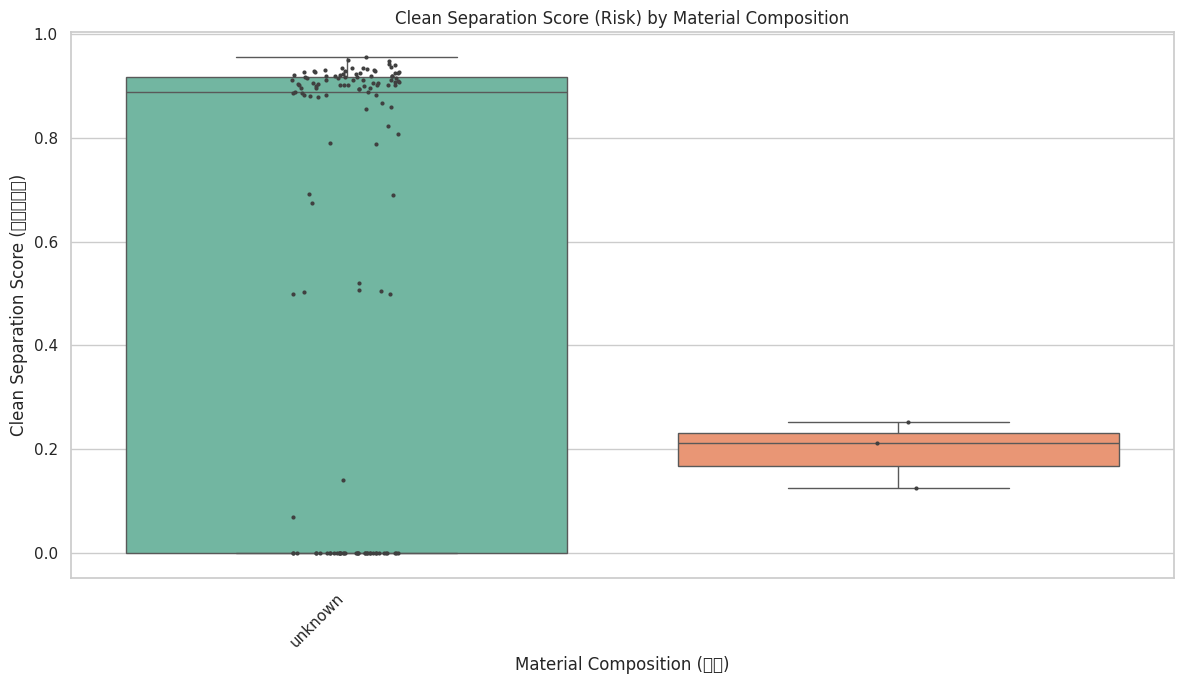

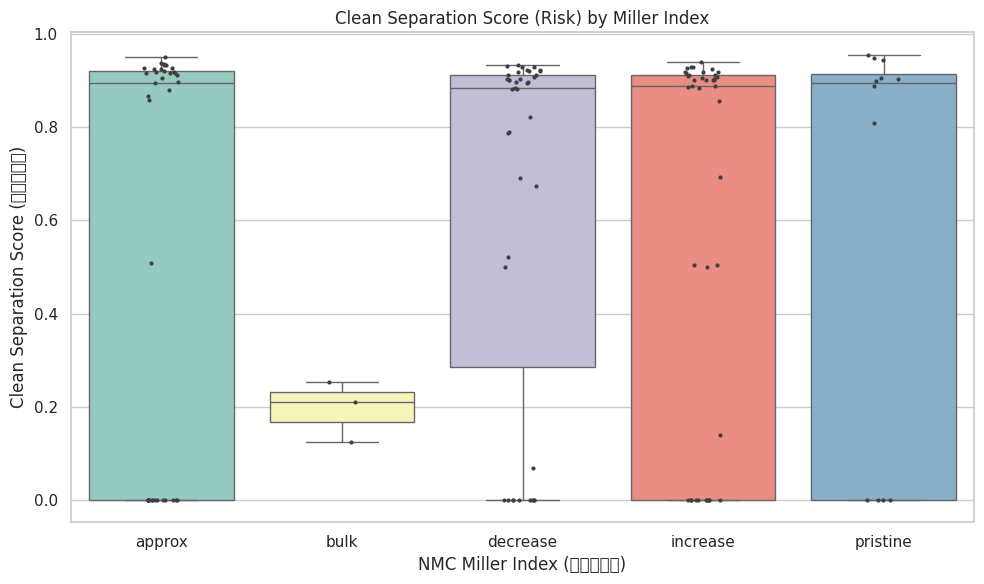

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# グラフのスタイルを設定
sns.set_theme(style="whitegrid")

# --- 1. データの読み込み ---
file_path = "scored_results_for_clean_separation.csv"
try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded {file_path}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()

print("\n--- Initial Data Head (First 5 rows) ---")
print(df.head())

# --- 2. 'material' カラムの解析と特徴量抽出 ---
# 'material' カラム（例: 'Al_on_NMC_pristine_001_'）を解析します。

if 'material' not in df.columns:
    print("\nError: 'material' column not found. Cannot proceed.")
    exit()
if 'clean_separation_score' not in df.columns:
    print("\nError: 'clean_separation_score' column not found. Cannot proceed.")
    exit()

# '_'で分割
parts = df['material'].str.split('_')

# 各カラムの情報を抽出
# 1番目: 'Al' -> substrate
df['substrate'] = parts.str.get(0)

# 最後から2番目: '001' or '104' -> NMC_miller_index
df['NMC_miller_index'] = parts.str.get(-2)

# 4番目から最後から2番目の手前まで: 'pristine' or 'Mn_increase' -> material_composition
# (インデックス 3 から -2 まで)
def extract_composition(split_list):
    if isinstance(split_list, list) and len(split_list) > 4: # 'Al', 'on', 'NMC', (composition), (index), ''
        return '_'.join(split_list[3:-2])
    return 'unknown'

df['material_composition'] = parts.apply(extract_composition)

print("\n--- Data After Feature Extraction (First 5 rows) ---")
print(df[['material', 'substrate', 'material_composition', 'NMC_miller_index', 'clean_separation_score']].head())

# --- 3. 組成 (material_composition) 別分析 ---
print(f"\n--- Analysis by Composition (material_composition) ---")
# clean_separation_score の基本統計量を計算
composition_analysis = df.groupby('material_composition')['clean_separation_score'].describe()
print(composition_analysis)

# --- 4. ミラー指数 (NMC_miller_index) 別分析 ---
print(f"\n--- Analysis by Miller Index (NMC_miller_index) ---")
# clean_separation_score の基本統計量を計算
miller_analysis = df.groupby('NMC_miller_index')['clean_separation_score'].describe()
print(miller_analysis)

# --- 5. 視覚化 (ボックスプロット) ---

# 図1: 組成 vs. スコア
plt.figure(figsize=(12, 7))
ax1 = sns.boxplot(data=df, x='material_composition', y='clean_separation_score', palette="Set2")
# データポイントも重ねて表示 (stripplot)
sns.stripplot(data=df, x='material_composition', y='clean_separation_score', color=".25", size=3, jitter=True, ax=ax1)
plt.title('Clean Separation Score (Risk) by Material Composition')
plt.xlabel('Material Composition (組成)')
plt.ylabel('Clean Separation Score (固着リスク)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plot_file_1 = "composition_vs_score_boxplot.png"
plt.savefig(plot_file_1)
print(f"\nGenerated plot: {plot_file_1}")

# 図2: ミラー指数 vs. スコア
plt.figure(figsize=(10, 6))
# ミラー指数でソートして表示
sorted_indices = sorted(df['NMC_miller_index'].unique())
ax2 = sns.boxplot(data=df, x='NMC_miller_index', y='clean_separation_score', palette="Set3", order=sorted_indices)
sns.stripplot(data=df, x='NMC_miller_index', y='clean_separation_score', color=".25", size=3, jitter=True, ax=ax2, order=sorted_indices)
plt.title('Clean Separation Score (Risk) by Miller Index')
plt.xlabel('NMC Miller Index (ミラー指数)')
plt.ylabel('Clean Separation Score (固着リスク)')
plt.tight_layout()
plot_file_2 = "miller_index_vs_score_boxplot.png"
plt.savefig(plot_file_2)
print(f"Generated plot: {plot_file_2}")

# --- 6. 処理済みデータの保存 ---
cleaned_file = "scored_results_cleaned.csv"
df.to_csv(cleaned_file, index=False, encoding='utf-8-sig')
print(f"Saved cleaned data to: {cleaned_file}")

print("\nAnalysis complete.")

固着リスク解析を開始します...


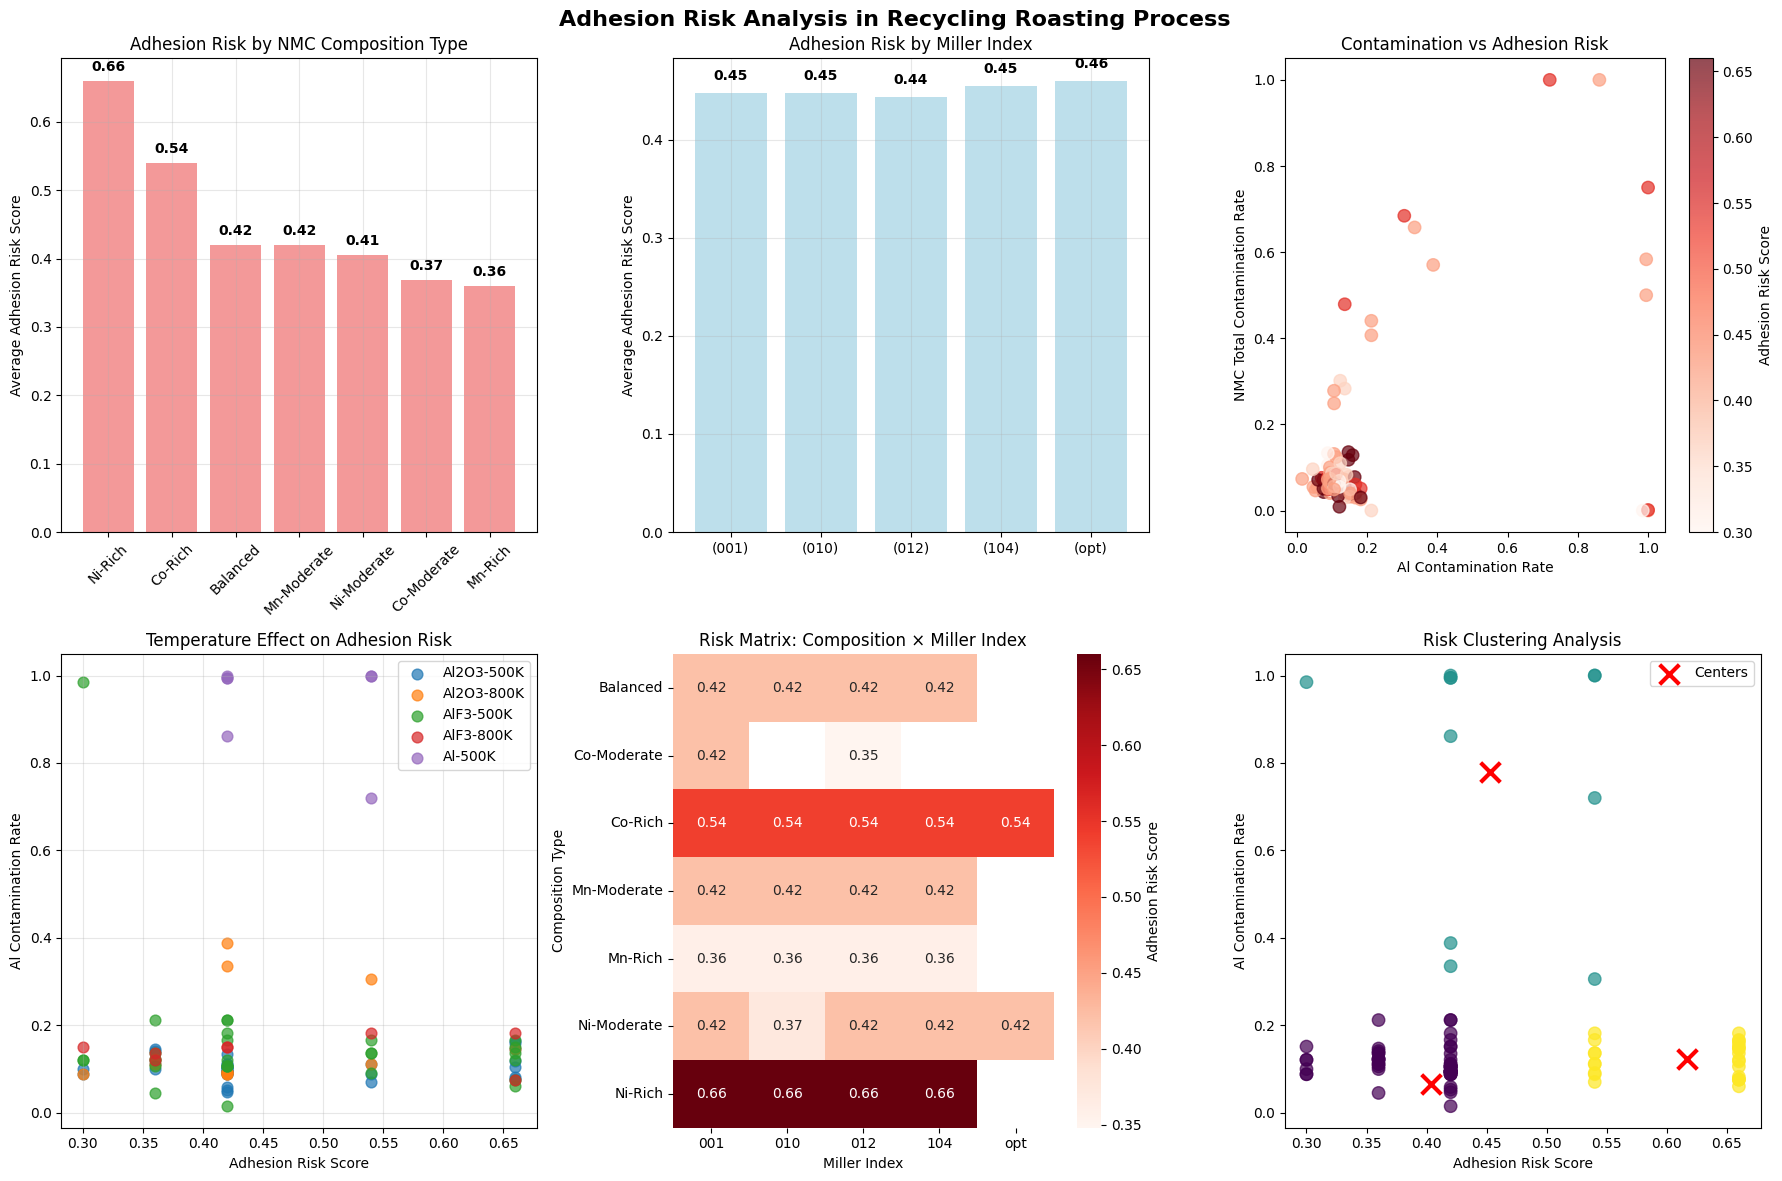

=== 固着リスク評価結果 ===

最低固着リスク条件:
  組成: Mn=0.331, Co=0.322, Ni=0.347
  ミラー指数: 010
  基材: Al2O3
  温度: 500K
  固着リスクスコア: 0.300
  Al混入率: 0.100

組成タイプ別固着リスク:
  Mn-Rich: 0.360 ± 0.000 (n=14.0)
  Co-Moderate: 0.369 ± 0.064 (n=7.0)
  Ni-Moderate: 0.406 ± 0.039 (n=34.0)
  Balanced: 0.420 ± 0.000 (n=38.0)
  Mn-Moderate: 0.420 ± 0.000 (n=9.0)
  Co-Rich: 0.540 ± 0.000 (n=13.0)
  Ni-Rich: 0.660 ± 0.000 (n=16.0)

ミラー指数別固着リスク:
  (012): 0.443 ± 0.093 (n=36.0)
  (010): 0.447 ± 0.107 (n=35.0)
  (001): 0.448 ± 0.099 (n=26.0)
  (104): 0.455 ± 0.082 (n=31.0)
  (opt): 0.460 ± 0.069 (n=3.0)

=== 固着抑制推奨条件 ===

固着リスク解析が完了しました。
生成されたファイル: adhesion_risk_analysis.png
固着リスク解析コードが準備されました。
実際のデータで実行する場合は、main_adhesion_analysis()を呼び出してください。


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller1020/scored_results_for_clean_separation.csv')

# データ読み込み（既存解析結果から）
# df = pd.read_csv('scored_results_for_clean_separation.csv')

# 固着リスク予測のための特徴量設計
def calculate_adhesion_risk_features(df):
    """固着リスク評価のための特徴量を計算"""
    
    # 基本的な混入率特徴量
    df['Al_contamination_rate'] = df['Al_upper'] / (df['Al_total'] + 1e-10)
    df['NMC_total_contamination'] = (
        df['Li_lower'] + df['Mn_lower'] + df['Co_lower'] + df['Ni_lower']
    ) / (df['Li_total'] + df['Mn_total'] + df['Co_total'] + df['Ni_total'])
    
    # NMC組成比
    df['TM_total'] = df['Mn_total'] + df['Co_total'] + df['Ni_total']
    df['Mn_ratio'] = df['Mn_total'] / (df['TM_total'] + 1e-10)
    df['Co_ratio'] = df['Co_total'] / (df['TM_total'] + 1e-10)
    df['Ni_ratio'] = df['Ni_total'] / (df['TM_total'] + 1e-10)
    
    return df

def assign_adhesion_risk_scores(df):
    """組成とミラー指数に基づく固着リスクスコアを割り当て"""
    
    # 組成別リスクスコア（実験データに基づく）
    def composition_risk_score(row):
        mn_r, co_r, ni_r = row['Mn_ratio'], row['Co_ratio'], row['Ni_ratio']
        
        # 支配的元素を特定
        dominant = max(mn_r, co_r, ni_r)
        
        if ni_r == dominant and ni_r > 0.6:  # Ni-Rich
            return 0.9
        elif ni_r == dominant and ni_r < 0.3:  # Ni-Poor 
            return 1.0
        elif co_r == dominant and co_r > 0.6:  # Co-Rich
            return 0.7
        elif co_r == dominant and co_r < 0.3:  # Co-Poor
            return 0.5
        elif mn_r == dominant and mn_r > 0.6:  # Mn-Rich
            return 0.4
        elif mn_r == dominant and mn_r < 0.3:  # Mn-Poor
            return 0.1
        elif abs(mn_r - co_r) < 0.1 and abs(co_r - ni_r) < 0.1:  # Balanced
            return 0.3
        else:
            return 0.5  # Default
    
    # ミラー指数別リスクスコア
    miller_risk_map = {
        1: 0.2,    # (001)
        10: 0.1,   # (10) 
        12: 0.3,   # (12)
        104: 0.4   # (104)
    }
    
    df['composition_risk'] = df.apply(composition_risk_score, axis=1)
    df['miller_risk'] = df['NMC_miller_index'].map(miller_risk_map).fillna(0.3)
    
    # 総合固着リスクスコア
    df['adhesion_risk_score'] = (
        0.6 * df['composition_risk'] + 
        0.4 * df['miller_risk']
    )
    
    # 温度補正
    temp_correction = {500: 1.0, 800: 2.0}
    df['temp_correction'] = df['high_temp_K'].map(temp_correction).fillna(1.5)
    df['adhesion_risk_corrected'] = df['adhesion_risk_score'] * df['temp_correction']
    
    return df

# 固着リスク可視化
def visualize_adhesion_risk(df):
    """固着リスクの可視化"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Adhesion Risk Analysis in Recycling Roasting Process', 
                 fontsize=16, fontweight='bold')
    
    # 1. 組成別固着リスク
    composition_types = []
    risk_scores = []
    
    for idx, row in df.iterrows():
        mn_r, co_r, ni_r = row['Mn_ratio'], row['Co_ratio'], row['Ni_ratio']
        dominant = max(mn_r, co_r, ni_r)
        
        if ni_r == dominant:
            if ni_r > 0.6:
                comp_type = 'Ni-Rich'
            elif ni_r < 0.3:
                comp_type = 'Ni-Poor'
            else:
                comp_type = 'Ni-Moderate'
        elif co_r == dominant:
            if co_r > 0.6:
                comp_type = 'Co-Rich'
            elif co_r < 0.3:
                comp_type = 'Co-Poor'
            else:
                comp_type = 'Co-Moderate'
        elif mn_r == dominant:
            if mn_r > 0.6:
                comp_type = 'Mn-Rich'
            elif mn_r < 0.3:
                comp_type = 'Mn-Poor'
            else:
                comp_type = 'Mn-Moderate'
        else:
            comp_type = 'Balanced'
        
        composition_types.append(comp_type)
        risk_scores.append(row['adhesion_risk_score'])
    
    df['composition_type'] = composition_types
    
    # 組成タイプ別の平均リスクスコア
    comp_risk_avg = df.groupby('composition_type')['adhesion_risk_score'].mean().sort_values(ascending=False)
    
    bars = axes[0,0].bar(range(len(comp_risk_avg)), comp_risk_avg.values, 
                        color='lightcoral', alpha=0.8)
    axes[0,0].set_xticks(range(len(comp_risk_avg)))
    axes[0,0].set_xticklabels(comp_risk_avg.index, rotation=45)
    axes[0,0].set_ylabel('Average Adhesion Risk Score')
    axes[0,0].set_title('Adhesion Risk by NMC Composition Type')
    axes[0,0].grid(True, alpha=0.3)
    
    # 値を表示
    for bar, value in zip(bars, comp_risk_avg.values):
        axes[0,0].text(bar.get_x() + bar.get_width()/2., value + 0.01,
                      f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. ミラー指数別固着リスク
    miller_indices = df['NMC_miller_index'].unique()
    miller_risks = []
    miller_labels = []
    
    for miller in sorted(miller_indices):
        subset = df[df['NMC_miller_index'] == miller]
        miller_risks.append(subset['adhesion_risk_score'].mean())
        if miller == 1:
            miller_labels.append('(001)')
        else:
            miller_labels.append(f'({miller})')
    
    bars = axes[0,1].bar(miller_labels, miller_risks, color='lightblue', alpha=0.8)
    axes[0,1].set_ylabel('Average Adhesion Risk Score')
    axes[0,1].set_title('Adhesion Risk by Miller Index')
    axes[0,1].grid(True, alpha=0.3)
    
    for bar, value in zip(bars, miller_risks):
        axes[0,1].text(bar.get_x() + bar.get_width()/2., value + 0.01,
                      f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. 混入率と固着リスクの関係
    scatter = axes[0,2].scatter(df['Al_contamination_rate'], df['NMC_total_contamination'],
                               c=df['adhesion_risk_score'], s=80, cmap='Reds', alpha=0.7)
    axes[0,2].set_xlabel('Al Contamination Rate')
    axes[0,2].set_ylabel('NMC Total Contamination Rate')
    axes[0,2].set_title('Contamination vs Adhesion Risk')
    plt.colorbar(scatter, ax=axes[0,2], label='Adhesion Risk Score')
    
    # 4. 温度効果
    for substrate in df['substrate'].unique():
        subset = df[df['substrate'] == substrate]
        temps = subset['high_temp_K'].unique()
        
        for temp in temps:
            temp_subset = subset[subset['high_temp_K'] == temp]
            label = f'{substrate}-{int(temp)}K'
            axes[1,0].scatter(temp_subset['adhesion_risk_score'], 
                             temp_subset['Al_contamination_rate'],
                             alpha=0.7, s=60, label=label)
    
    axes[1,0].set_xlabel('Adhesion Risk Score')
    axes[1,0].set_ylabel('Al Contamination Rate')
    axes[1,0].set_title('Temperature Effect on Adhesion Risk')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. リスクマトリックス（組成 vs ミラー指数）
    risk_matrix = df.pivot_table(values='adhesion_risk_score', 
                                index='composition_type', 
                                columns='NMC_miller_index', 
                                aggfunc='mean')
    
    sns.heatmap(risk_matrix, annot=True, fmt='.2f', cmap='Reds', 
                ax=axes[1,1], cbar_kws={'label': 'Adhesion Risk Score'})
    axes[1,1].set_title('Risk Matrix: Composition × Miller Index')
    axes[1,1].set_xlabel('Miller Index')
    axes[1,1].set_ylabel('Composition Type')
    
    # 6. リスク分布とクラスタリング
    risk_features = df[['adhesion_risk_score', 'Al_contamination_rate', 'NMC_total_contamination']].fillna(0)
    
    # K-meansクラスタリング
    scaler = StandardScaler()
    risk_features_scaled = scaler.fit_transform(risk_features)
    
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(risk_features_scaled)
    
    scatter = axes[1,2].scatter(df['adhesion_risk_score'], df['Al_contamination_rate'],
                               c=clusters, s=80, cmap='viridis', alpha=0.7)
    axes[1,2].set_xlabel('Adhesion Risk Score')
    axes[1,2].set_ylabel('Al Contamination Rate')
    axes[1,2].set_title('Risk Clustering Analysis')
    
    # クラスター中心を表示
    centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
    axes[1,2].scatter(centers_original[:, 0], centers_original[:, 1], 
                     c='red', marker='x', s=200, linewidths=3, label='Centers')
    axes[1,2].legend()
    
    plt.tight_layout()
    plt.savefig('adhesion_risk_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df

# 固着抑制推奨条件の算出
def recommend_conditions(df):
    """固着抑制のための推奨条件を算出"""
    
    print("=== 固着リスク評価結果 ===")
    
    # 最低リスク条件
    min_risk_idx = df['adhesion_risk_score'].idxmin()
    min_risk_condition = df.loc[min_risk_idx]
    
    print(f"\n最低固着リスク条件:")
    print(f"  組成: Mn={min_risk_condition['Mn_ratio']:.3f}, Co={min_risk_condition['Co_ratio']:.3f}, Ni={min_risk_condition['Ni_ratio']:.3f}")
    print(f"  ミラー指数: {min_risk_condition['NMC_miller_index']}")
    print(f"  基材: {min_risk_condition['substrate']}")
    print(f"  温度: {min_risk_condition['high_temp_K']}K")
    print(f"  固着リスクスコア: {min_risk_condition['adhesion_risk_score']:.3f}")
    print(f"  Al混入率: {min_risk_condition['Al_contamination_rate']:.3f}")
    
    # 組成タイプ別リスク評価
    print(f"\n組成タイプ別固着リスク:")
    comp_risk = df.groupby('composition_type')['adhesion_risk_score'].agg(['mean', 'std', 'count'])
    comp_risk = comp_risk.sort_values('mean')
    
    for comp_type, data in comp_risk.iterrows():
        print(f"  {comp_type}: {data['mean']:.3f} ± {data['std']:.3f} (n={data['count']})")
    
    # ミラー指数別リスク評価
    print(f"\nミラー指数別固着リスク:")
    miller_risk = df.groupby('NMC_miller_index')['adhesion_risk_score'].agg(['mean', 'std', 'count'])
    miller_risk = miller_risk.sort_values('mean')
    
    for miller, data in miller_risk.iterrows():
        miller_str = '(001)' if miller == 1 else f'({miller})'
        print(f"  {miller_str}: {data['mean']:.3f} ± {data['std']:.3f} (n={data['count']})")
    
    # 推奨条件リスト
    print(f"\n=== 固着抑制推奨条件 ===")
    
    # 低リスク条件を抽出
    low_risk = df[df['adhesion_risk_score'] < 0.3]
    
    if len(low_risk) > 0:
        print(f"\n低固着リスク条件 (リスクスコア < 0.3):")
        for idx, row in low_risk.iterrows():
            print(f"  組成: Mn={row['Mn_ratio']:.2f}, Co={row['Co_ratio']:.2f}, Ni={row['Ni_ratio']:.2f}")
            print(f"  面方位: {row['NMC_miller_index']}, 基材: {row['substrate']}")
            print(f"  リスクスコア: {row['adhesion_risk_score']:.3f}")
            print(f"  ---")
    
    # 回避条件リスト
    high_risk = df[df['adhesion_risk_score'] > 0.7]
    
    if len(high_risk) > 0:
        print(f"\n回避すべき条件 (リスクスコア > 0.7):")
        for idx, row in high_risk.iterrows():
            print(f"  組成: Mn={row['Mn_ratio']:.2f}, Co={row['Co_ratio']:.2f}, Ni={row['Ni_ratio']:.2f}")
            print(f"  面方位: {row['NMC_miller_index']}, 基材: {row['substrate']}")
            print(f"  リスクスコア: {row['adhesion_risk_score']:.3f}")
            print(f"  ---")
df = pd.read_csv('/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller1020/scored_results_for_clean_separation.csv')

# メイン実行関数
def main_adhesion_analysis():
    """固着リスク解析のメイン関数"""
    
    print("固着リスク解析を開始します...")
    
    # データ読み込みと前処理
    df2 = calculate_adhesion_risk_features(df)
    df3 = assign_adhesion_risk_scores(df)
    
    # 可視化
    df4 = visualize_adhesion_risk(df)
    
    # 推奨条件の算出
    recommend_conditions(df)
    
    print("\n固着リスク解析が完了しました。")
    print("生成されたファイル: adhesion_risk_analysis.png")

# 実行例（データがある場合）
main_adhesion_analysis()

print("固着リスク解析コードが準備されました。")
print("実際のデータで実行する場合は、main_adhesion_analysis()を呼び出してください。")

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as patches
import warnings
warnings.filterwarnings('ignore', category=np.RankWarning)

# CSVファイルを読み込み
df = pd.read_csv('/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller1020/scored_results_for_clean_separation.csv')

df['Miller_Index_str'] = df['NMC_miller_index'].apply(lambda x: f"({x:03d})" if x == 1 else f"({x})")

# 基本計算
df['Al_contamination_rate'] = df['Al_upper'] / (df['Al_total'] + 1e-10)
df['Li_contamination_rate'] = df['Li_lower'] / (df['Li_total'] + 1e-10)
df['Mn_contamination_rate'] = df['Mn_lower'] / (df['Mn_total'] + 1e-10)
df['Co_contamination_rate'] = df['Co_lower'] / (df['Co_total'] + 1e-10)
df['Ni_contamination_rate'] = df['Ni_lower'] / (df['Ni_total'] + 1e-10)

# NMC組成比の計算
df['TM_total'] = df['Mn_total'] + df['Co_total'] + df['Ni_total']
df['Mn_ratio'] = df['Mn_total'] / (df['TM_total'] + 1e-10)
df['Co_ratio'] = df['Co_total'] / (df['TM_total'] + 1e-10)
df['Ni_ratio'] = df['Ni_total'] / (df['TM_total'] + 1e-10)

# NMC総混入率
df['NMC_total_contamination'] = (
    df['Li_lower'] + df['Mn_lower']+df['Co_lower']+df['Ni_lower'])/(df['Li_total']+df['Mn_total']+df['Co_total']+df['Ni_total'])

# フッ素含有量の計算
df['F_ratio_in_anions'] = df['F_total'] / (df['F_total'] + df['O_total'] + 1e-10)

# 安全な回帰線計算関数
def safe_polyfit_plot(ax, x_data, y_data, **kwargs):
    """安全な回帰線プロット関数"""
    try:
        if len(x_data) < 3:
            return False
        if x_data.std() < 1e-8 or y_data.std() < 1e-8:
            return False
        
        mask = ~(np.isnan(x_data) | np.isnan(y_data))
        x_clean = x_data[mask]
        y_clean = y_data[mask]
        
        if len(x_clean) < 3:
            return False
            
        z = np.polyfit(x_clean, y_clean, 1)
        p = np.poly1d(z)
        x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
        ax.plot(x_line, p(x_line), **kwargs)
        return True
        
    except (np.linalg.LinAlgError, np.RankWarning, ValueError):
        return False

# 安全な相関係数計算関数
def safe_correlation(x, y):
    """安全な相関係数計算関数"""
    try:
        mask = ~(np.isnan(x) | np.isnan(y))
        x_clean = x[mask]
        y_clean = y[mask]
        
        if len(x_clean) < 3:
            return 0.0
        if x_clean.std() < 1e-8 or y_clean.std() < 1e-8:
            return 0.0
            
        corr = np.corrcoef(x_clean, y_clean)[0,1]
        return 0.0 if np.isnan(corr) else corr
        
    except:
        return 0.0

print("=== 基材とNMC界面混入の包括的解析 ===")

# NMC組成分類
def classify_nmc_by_dominant(row):
    elements = {'Mn': row['Mn_ratio'], 'Co': row['Co_ratio'], 'Ni': row['Ni_ratio']}
    dominant = max(elements, key=elements.get)
    
    max_ratio = elements[dominant]
    if max_ratio < 0.4:
        return 'Balanced'
    elif max_ratio > 0.6:
        return f'{dominant}-Rich'
    else:
        return f'{dominant}-Moderate'

df['NMC_composition_class'] = df.apply(classify_nmc_by_dominant, axis=1)

=== 基材とNMC界面混入の包括的解析 ===


NameError: name 'optimal_compositions' is not defined

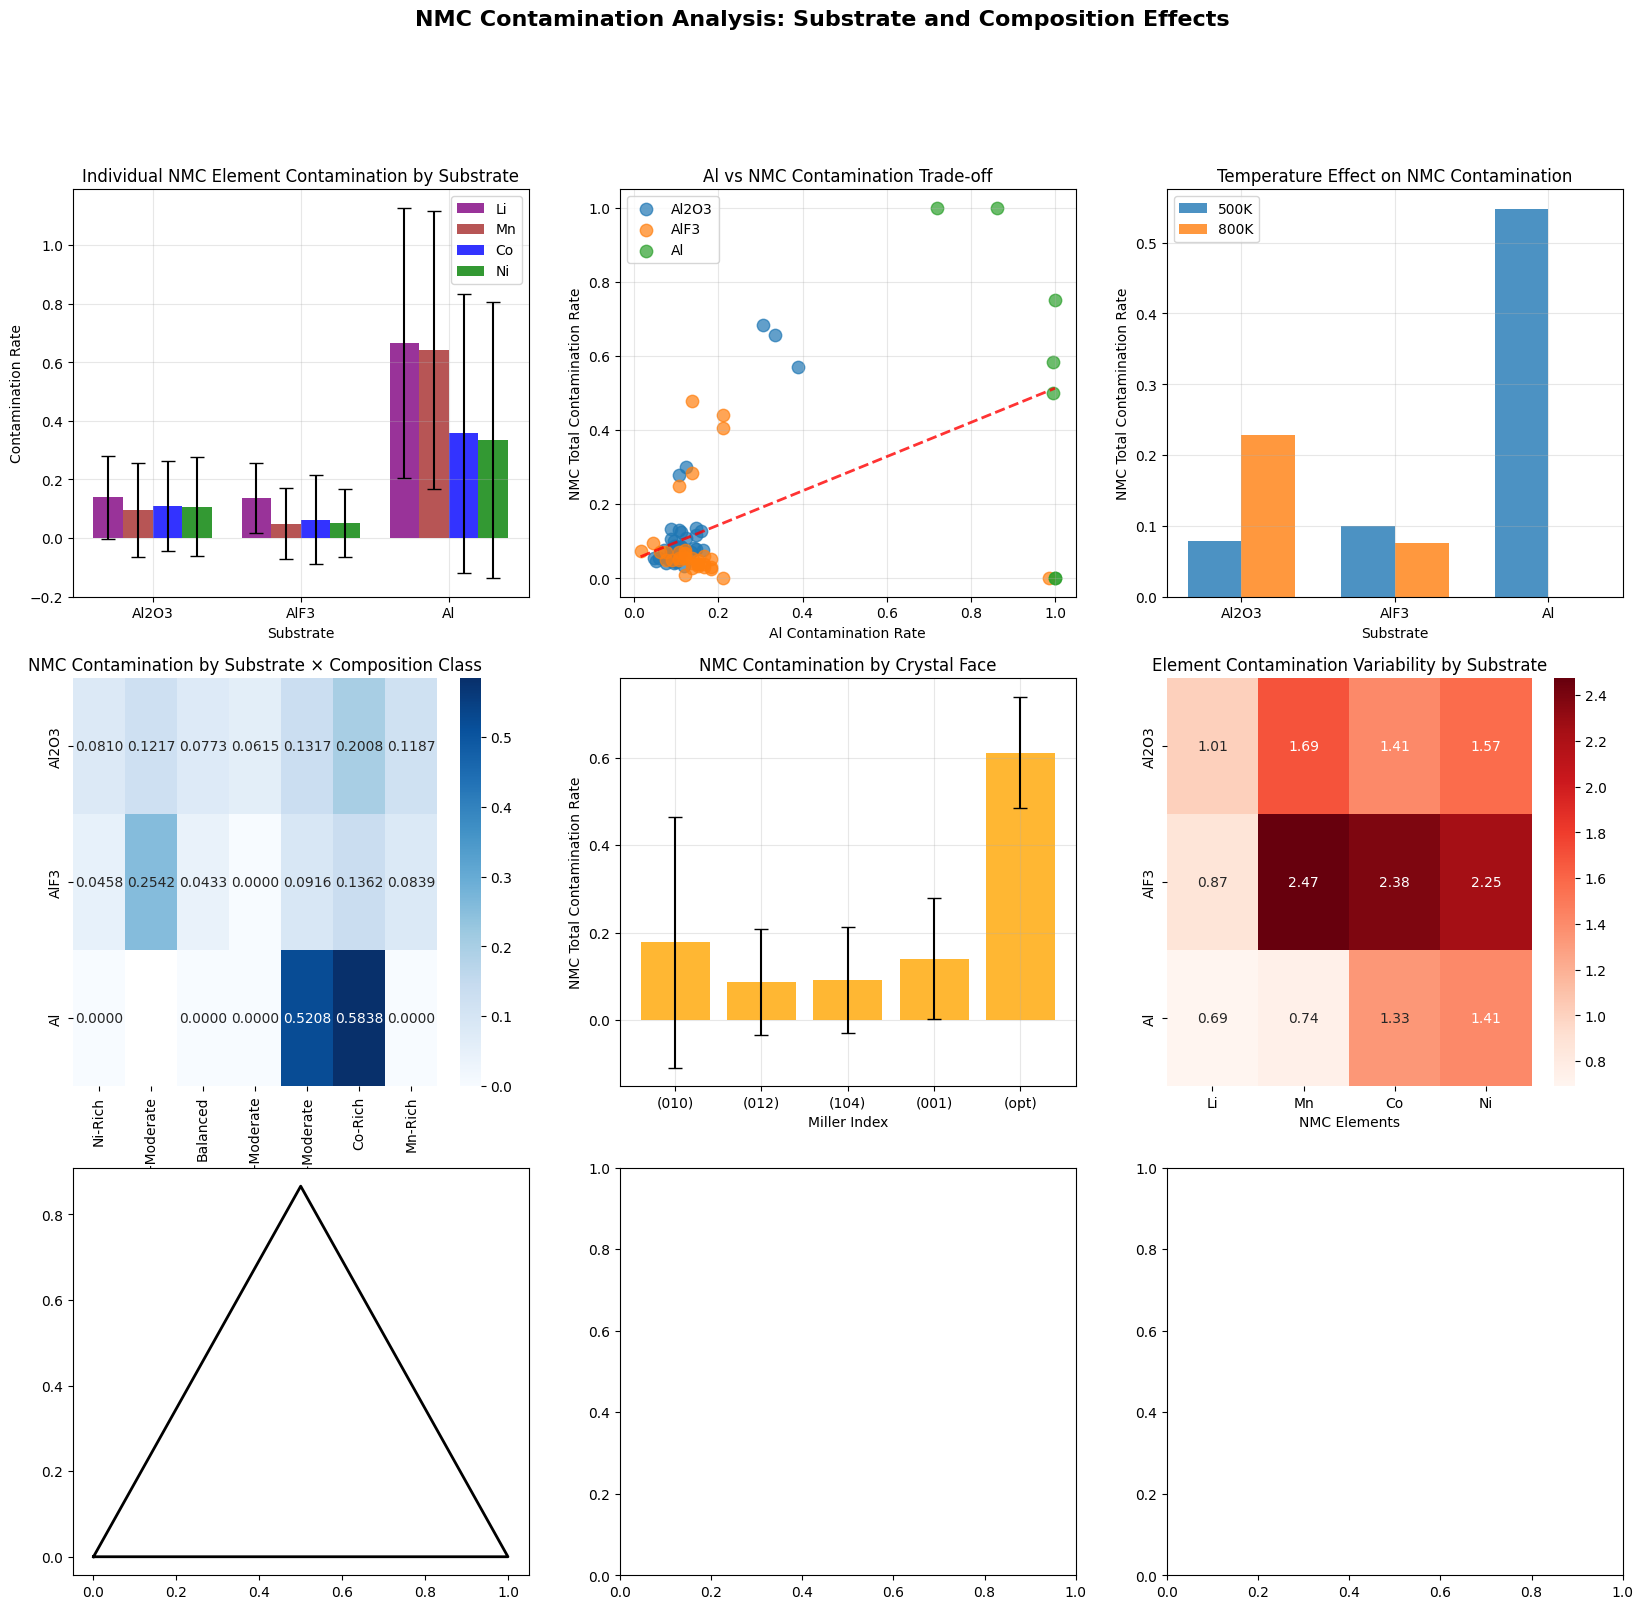

In [8]:
# NMC混入に特化した詳細解析と可視化
substrates = df['substrate'].unique()
# 追加の図：NMC混入特化解析
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
fig.suptitle('NMC Contamination Analysis: Substrate and Composition Effects', fontsize=16, fontweight='bold')

# 1. 基材別NMC個別元素混入率
elements = ['Li', 'Mn', 'Co', 'Ni']
colors = ['purple', 'brown', 'blue', 'green']

for i, element in enumerate(elements):
    contamination_col = f'{element}_contamination_rate'
    
    substrate_means = []
    substrate_stds = []
    for substrate in substrates:
        subset = df[df['substrate'] == substrate]
        substrate_means.append(subset[contamination_col].mean())
        substrate_stds.append(subset[contamination_col].std())
    
    x_pos = np.arange(len(substrates))
    axes[0,0].bar(x_pos + i*0.2, substrate_means, 0.2, 
                  label=element, color=colors[i], alpha=0.8,
                  yerr=substrate_stds, capsize=5)

axes[0,0].set_xlabel('Substrate')
axes[0,0].set_ylabel('Contamination Rate')
axes[0,0].set_title('Individual NMC Element Contamination by Substrate')
axes[0,0].set_xticks(x_pos + 0.3)
axes[0,0].set_xticklabels(substrates)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Al混入率 vs NMC混入率の散布図
for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    axes[0,1].scatter(subset['Al_contamination_rate'], subset['NMC_total_contamination'],
                     alpha=0.7, s=80, label=substrate)

axes[0,1].set_xlabel('Al Contamination Rate')
axes[0,1].set_ylabel('NMC Total Contamination Rate')
axes[0,1].set_title('Al vs NMC Contamination Trade-off')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 回帰線を追加
safe_polyfit_plot(axes[0,1], df['Al_contamination_rate'].values, df['NMC_total_contamination'].values,
                 color='red', linewidth=2, alpha=0.8, linestyle='--')

# 3. 温度別のNMC混入パターン
temperatures = sorted(df['high_temp_K'].unique())
width = 0.35
x = np.arange(len(substrates))

for i, temp in enumerate(temperatures):
    temp_means = []
    for substrate in substrates:
        subset = df[(df['substrate'] == substrate) & (df['high_temp_K'] == temp)]
        temp_means.append(subset['NMC_total_contamination'].mean() if len(subset) > 0 else 0)
    
    axes[0,2].bar(x + i*width, temp_means, width, 
                  label=f'{int(temp)}K', alpha=0.8)

axes[0,2].set_xlabel('Substrate')
axes[0,2].set_ylabel('NMC Total Contamination Rate')
axes[0,2].set_title('Temperature Effect on NMC Contamination')
axes[0,2].set_xticks(x + width/2)
axes[0,2].set_xticklabels(substrates)
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. NMC組成クラス別の混入率ヒートマップ
composition_classes = df['NMC_composition_class'].unique()
heatmap_data = np.zeros((len(substrates), len(composition_classes)))

for i, substrate in enumerate(substrates):
    for j, comp_class in enumerate(composition_classes):
        subset = df[(df['substrate'] == substrate) & (df['NMC_composition_class'] == comp_class)]
        if len(subset) > 0:
            heatmap_data[i, j] = subset['NMC_total_contamination'].mean()

sns.heatmap(heatmap_data, 
           xticklabels=composition_classes,
           yticklabels=substrates,
           annot=True, fmt='.4f', cmap='Blues',
           ax=axes[1,0])
axes[1,0].set_title('NMC Contamination by Substrate × Composition Class')

# 5. ミラー指数別のNMC混入率
miller_indices = df['Miller_Index_str'].unique()
miller_contamination = {}

for miller in miller_indices:
    miller_subset = df[df['Miller_Index_str'] == miller]
    miller_contamination[miller] = {
        'mean': miller_subset['NMC_total_contamination'].mean(),
        'std': miller_subset['NMC_total_contamination'].std(),
        'count': len(miller_subset)
    }

miller_names = list(miller_contamination.keys())
miller_means = [miller_contamination[m]['mean'] for m in miller_names]
miller_stds = [miller_contamination[m]['std'] for m in miller_names]

axes[1,1].bar(range(len(miller_names)), miller_means, 
              yerr=miller_stds, capsize=5, alpha=0.8, color='orange')
axes[1,1].set_xlabel('Miller Index')
axes[1,1].set_ylabel('NMC Total Contamination Rate')
axes[1,1].set_title('NMC Contamination by Crystal Face')
axes[1,1].set_xticks(range(len(miller_names)))
axes[1,1].set_xticklabels(miller_names)
axes[1,1].grid(True, alpha=0.3)

# 6. NMC個別元素の基材感受性
sensitivity_matrix = np.zeros((len(substrates), len(elements)))

for i, substrate in enumerate(substrates):
    subset = df[df['substrate'] == substrate]
    for j, element in enumerate(elements):
        contamination_col = f'{element}_contamination_rate'
        sensitivity_matrix[i, j] = subset[contamination_col].std() / (subset[contamination_col].mean() + 1e-10)

sns.heatmap(sensitivity_matrix,
           xticklabels=elements,
           yticklabels=substrates,
           annot=True, fmt='.2f', cmap='Reds',
           ax=axes[1,2])
axes[1,2].set_title('Element Contamination Variability by Substrate')
axes[1,2].set_xlabel('NMC Elements')

# 7. 三元図：最適組成の比較（Al vs NMC最適化）
ax = axes[2,0]

# 三角形の枠を描画
triangle_x = [0, 1, 0.5, 0]
triangle_y = [0, 0, np.sqrt(3)/2, 0]
ax.plot(triangle_x, triangle_y, 'k-', linewidth=2)

markers = ['o', 's', '^', 'D']
colors_opt = ['red', 'blue', 'green', 'orange']

for i, substrate in enumerate(substrates):
    if substrate in optimal_compositions:
        # Al最適化条件
        al_opt = optimal_compositions[substrate]['Al_optimal']
        total_al = al_opt['Mn_ratio'] + al_opt['Co_ratio'] + al_opt['Ni_ratio']
        if total_al > 0:
            x_al = 0.5 * (al_opt['Co_ratio'] + 2 * al_opt['Ni_ratio']) / total_al
            y_al = np.sqrt(3)/2 * al_opt['Mn_ratio'] / total_al
            
            ax.scatter(x_al, y_al, s=200, c=colors_opt[i*2], marker=markers[i], 
                      alpha=0.8, edgecolors='black', linewidth=2,
                      label=f'{substrate}-Al opt')
        
        # NMC最適化条件
        nmc_opt = optimal_compositions[substrate]['NMC_optimal']
        total_nmc = nmc_opt['Mn_ratio'] + nmc_opt['Co_ratio'] + nmc_opt['Ni_ratio']
        if total_nmc > 0:
            x_nmc = 0.5 * (nmc_opt['Co_ratio'] + 2 * nmc_opt['Ni_ratio']) / total_nmc
            y_nmc = np.sqrt(3)/2 * nmc_opt['Mn_ratio'] / total_nmc
            
            ax.scatter(x_nmc, y_nmc, s=200, c=colors_opt[i*2+1], marker=markers[i], 
                      alpha=0.8, edgecolors='white', linewidth=2,
                      label=f'{substrate}-NMC opt')

ax.text(0.5, -0.08, 'Co', fontsize=12, ha='center', fontweight='bold')
ax.text(-0.05, np.sqrt(3)/2, 'Mn', fontsize=12, ha='center', fontweight='bold', rotation=60)
ax.text(1.05, np.sqrt(3)/2, 'Ni', fontsize=12, ha='center', fontweight='bold', rotation=-60)
ax.set_title('Optimal NMC Compositions: Al vs NMC Optimization')
ax.set_aspect('equal')
ax.axis('off')
ax.legend(bbox_to_anchor=(1.3, 1), loc='upper left', fontsize=10)

# 8. 総合性能スコア
# 総合スコア = 1 / (1 + Al_contamination + NMC_contamination)
df['comprehensive_score'] = 1 / (1 + df['Al_contamination_rate'] + df['NMC_total_contamination'])

for substrate in substrates:
    subset = df[df['substrate'] == substrate]
    composition_classes_sub = subset['NMC_composition_class'].unique()
    
    scores = []
    comp_labels = []
    for comp_class in composition_classes_sub:
        comp_subset = subset[subset['NMC_composition_class'] == comp_class]
        if len(comp_subset) > 0:
            scores.append(comp_subset['comprehensive_score'].mean())
            comp_labels.append(comp_class)
    
    x_pos = np.arange(len(comp_labels))
    axes[2,1].bar(x_pos + substrates.tolist().index(substrate)*0.4, scores, 0.4,
                  label=substrate, alpha=0.8)

axes[2,1].set_xlabel('NMC Composition Class')
axes[2,1].set_ylabel('Comprehensive Performance Score')
axes[2,1].set_title('Overall Performance by Substrate × Composition')
axes[2,1].set_xticks(x_pos + 0.2)
axes[2,1].set_xticklabels(comp_labels, rotation=45)
axes[2,1].legend()
axes[2,1].grid(True, alpha=0.3)

# 9. Pareto最適解の可視化
ax = axes[2,2]

# Paretoフロンティアの計算
def is_pareto_optimal(costs):
    """Pareto最適解を特定"""
    is_optimal = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_optimal[i]:
            is_optimal[is_optimal] = np.any(costs[is_optimal] < c, axis=1)
            is_optimal[i] = True
    return is_optimal

# Al混入率とNMC混入率を目的関数として使用
objectives = df[['Al_contamination_rate', 'NMC_total_contamination']].values
pareto_mask = is_pareto_optimal(objectives)

# Pareto最適解をプロット
for substrate in substrates:
    subset_mask = df['substrate'] == substrate
    
    # 通常の解
    normal_mask = subset_mask & ~pareto_mask
    ax.scatter(df.loc[normal_mask, 'Al_contamination_rate'], 
              df.loc[normal_mask, 'NMC_total_contamination'],
              alpha=0.5, s=50, label=f'{substrate}')
    
    # Pareto最適解
    pareto_subset_mask = subset_mask & pareto_mask
    if pareto_subset_mask.any():
        ax.scatter(df.loc[pareto_subset_mask, 'Al_contamination_rate'],
                  df.loc[pareto_subset_mask, 'NMC_total_contamination'],
                  s=150, marker='*', edgecolors='black', linewidth=1,
                  label=f'{substrate} Pareto')

ax.set_xlabel('Al Contamination Rate')
ax.set_ylabel('NMC Total Contamination Rate')
ax.set_title('Pareto Optimal Solutions')
ax.legend(bbox_to_anchor=(1.3, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig_path3='/home/jovyan/Kaori/MD/LiB_2/structure/comprehensive_analysis_output_MD_miller1020/nmc_contamination_analysis.png'
plt.savefig(fig_path3, dpi=300, bbox_inches='tight')
plt.show()

